In [186]:
# transfer of learning for perturbation, using the idea of backprop + hebbian
# need to first find the optimum weight sum when perturbation, otherwise, the loss would shoot up
# it happens that not giving boundary to perturbation period while giving boundary to non-perturbation period produces the best result
# giving boundary might cause convergence to boundary (high loss), for example, when shifts want to jump below 1
# not giving boundary might sink into a local minimum where the loss is really low but gains and shifts are deviant from initial
# may not be generalizable, a better method for narrowing the boundary??
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
from training_abb05_bphebb import SimpleNeuralNetwork
from tqdm import tqdm

In [187]:
# load the pickle file
with open('weights_abb05_bphebb.pkl', 'rb') as f:
    model_rep = pickle.load(f)

In [188]:
# input and target
ndata = 200
xs = torch.linspace(0, 2 * torch.pi, ndata)
ys = torch.cos(xs)/4 + 0.5

In [189]:
# bp on weight to find the hebb alpha for perturbed network
# init
input_size = 230
init_gain = 3 * np.ones((input_size, 1))
init_shift = 1 * np.ones((input_size, 1))
init_weight = np.ones((1, input_size)) * 5.5 / input_size

# Training Loop
weight_epochs = 200
backprop_lr = 0.1

# define noise
np.random.seed(42)
W = np.eye(input_size) * 0.001
x_noises = (np.random.multivariate_normal(mean=np.zeros(input_size), cov=W, size=weight_epochs)).T * 0
x_noises = torch.tensor(x_noises, dtype=torch.float32)
x_noises += 0.1

# record
weight_losses = []
weight_sums = []
# weights = []

for epoch in tqdm(range(weight_epochs), position=0, leave=True):
    
    # establish model
    model = SimpleNeuralNetwork(input_size, init_gain, init_shift, init_weight)

    # shuffle data
    perm_idx = torch.randperm(ndata)
    shuffled_xs = xs[perm_idx]
    shuffled_ys = ys[perm_idx]
    epoch_loss = 0

    # go through all data
    for x, y in zip(shuffled_xs, shuffled_ys):  
        # forward
        inpu_ipl = model.gaussian_rf(x)
        actv_ipl = model.activation_func(model.gain * (inpu_ipl - model.shift)) + (x_noises[:, epoch]).reshape(-1, 1)
        # actv_ipl = model.activation_func(model.gain * (inpu_ipl - model.shift))
        model.input_activation = actv_ipl.clone()
        inpu_opl = torch.matmul(model.weights, actv_ipl)
        actv_opl = model.activation_func(3 * (inpu_opl - 1))
        model.output_activation = actv_opl.clone()          
        output = actv_opl.squeeze()
        # Calculate loss
        loss_func = nn.MSELoss()
        loss = 0.5 * loss_func(output, y)
        
        # backprop
        optimizer = optim.SGD([model.weights], lr=backprop_lr)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += loss.item()

    # update init
    init_gain = model.gain.detach().numpy()
    init_shift = model.shift.detach().numpy()
    init_weight = model.weights.detach().numpy()

    # record
    weight_losses.append(epoch_loss)
    weight_sums.append(np.sum(init_weight))

    # print out info
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}/{weight_epochs}, Loss: {epoch_loss}, Sum: {np.sum(init_weight)}')


  0%|          | 0/200 [00:00<?, ?it/s]

  2%|▏         | 4/200 [00:00<00:11, 17.29it/s]

Epoch 1/200, Loss: 0.2585266002112103, Sum: 3.4907066822052


  8%|▊         | 16/200 [00:00<00:05, 32.42it/s]

Epoch 11/200, Loss: 1.0441129280280848e-05, Sum: 3.480591297149658


 14%|█▍        | 28/200 [00:00<00:04, 36.84it/s]

Epoch 21/200, Loss: 7.997520811819925e-06, Sum: 3.480618476867676


 18%|█▊        | 36/200 [00:01<00:04, 38.21it/s]

Epoch 31/200, Loss: 7.108864399807402e-06, Sum: 3.48110294342041


 23%|██▎       | 46/200 [00:01<00:03, 39.50it/s]

Epoch 41/200, Loss: 7.816577515029621e-06, Sum: 3.482605457305908


 28%|██▊       | 55/200 [00:01<00:03, 39.66it/s]

Epoch 51/200, Loss: 7.110316776248737e-06, Sum: 3.4817991256713867


 34%|███▍      | 68/200 [00:01<00:03, 39.65it/s]

Epoch 61/200, Loss: 7.231354768322262e-06, Sum: 3.4810004234313965


 39%|███▉      | 78/200 [00:02<00:03, 39.98it/s]

Epoch 71/200, Loss: 6.726179945459876e-06, Sum: 3.4835314750671387


 43%|████▎     | 86/200 [00:02<00:02, 39.55it/s]

Epoch 81/200, Loss: 7.083317499656516e-06, Sum: 3.4824273586273193


 50%|████▉     | 99/200 [00:02<00:02, 40.01it/s]

Epoch 91/200, Loss: 6.445040610536523e-06, Sum: 3.481813907623291


 54%|█████▎    | 107/200 [00:02<00:02, 39.63it/s]

Epoch 101/200, Loss: 6.63160605363089e-06, Sum: 3.480344295501709


 58%|█████▊    | 116/200 [00:03<00:02, 39.74it/s]

Epoch 111/200, Loss: 6.496625298613168e-06, Sum: 3.480841636657715


 64%|██████▍   | 129/200 [00:03<00:01, 39.90it/s]

Epoch 121/200, Loss: 6.621893571701065e-06, Sum: 3.4804863929748535


 69%|██████▉   | 138/200 [00:03<00:01, 39.76it/s]

Epoch 131/200, Loss: 7.0471258655224744e-06, Sum: 3.4806861877441406


 73%|███████▎  | 146/200 [00:03<00:01, 39.58it/s]

Epoch 141/200, Loss: 6.557172124832533e-06, Sum: 3.481001615524292


 79%|███████▉  | 158/200 [00:04<00:01, 39.69it/s]

Epoch 151/200, Loss: 6.155103401628281e-06, Sum: 3.481921672821045


 84%|████████▎ | 167/200 [00:04<00:00, 39.68it/s]

Epoch 161/200, Loss: 7.044183797599857e-06, Sum: 3.4811673164367676


 88%|████████▊ | 175/200 [00:04<00:00, 39.39it/s]

Epoch 171/200, Loss: 7.536668412910785e-06, Sum: 3.480379581451416


 92%|█████████▏| 184/200 [00:04<00:00, 39.64it/s]

Epoch 181/200, Loss: 6.368030915471223e-06, Sum: 3.4825801849365234


 98%|█████████▊| 197/200 [00:05<00:00, 39.44it/s]

Epoch 191/200, Loss: 6.729676623518088e-06, Sum: 3.481217384338379


100%|██████████| 200/200 [00:05<00:00, 38.43it/s]


### Perturbation 500 Epochs

In [190]:
# perturbation for 2000 epochs
simu_epochs = 4000
perturb_start = 50
perturb_last = 2000
input_size = 230
theo_gain = 3 * np.ones((input_size, 1))
theo_shift = 1 * np.ones((input_size, 1))
init_gain = model_rep.gain.detach().numpy()
init_shift = model_rep.shift.detach().numpy()
init_weight = model_rep.weights.detach().numpy()
hebbian_lr = 0.03
max_hebbian_lr = 0.001
hebbian_up_rate = max_hebbian_lr / 200
hebb_alpha = 5.5
hebb_alpha_origin = 5.5
hebb_alpha_perturb = 3.5
hebb_alpha_up_rate = (hebb_alpha_perturb - hebb_alpha) / 200
backprop_lr = 0.2
has_backprop = True
has_boundary = False
has_hebbian = True
has_perturb = False

# define noise
np.random.seed(42)
W = np.eye(input_size) * 0.001
x_noises = (np.random.multivariate_normal(mean=np.zeros(input_size), cov=W, size=simu_epochs)).T * 0
x_noises = torch.tensor(x_noises, dtype=torch.float32)
x_noises[:,perturb_start:perturb_start+perturb_last] += 0.1

simu_losses = []
gain_changes = []
shift_changes = []
weight_sums = []
epoch_loss = 0

for epoch in tqdm(range(simu_epochs), position=0, leave=True):
    if epoch == perturb_start:
        has_perturb = True
        has_hebbian = False
        has_boundary = False
        hebbian_lr = 0
        print("perturbation start!!!")
    if epoch == perturb_start + perturb_last:
        has_perturb = False
        has_hebbian = False
        has_boundary = False
        hebbian_lr = 0
        print("perturbation end!!!")
    
    # if epoch == perturb_start + perturb_last + 15:
    #     break
    
    # shuffle data
    perm_idx = torch.randperm(ndata)
    shuffled_xs = xs[perm_idx]
    shuffled_ys = ys[perm_idx]
    last_epoch_loss = epoch_loss
    epoch_loss = 0
    hebbian_update = torch.zeros_like(torch.tensor(init_weight))

    # establish model
    model = SimpleNeuralNetwork(input_size, init_gain, init_shift, init_weight)

    # start hebbian and shrinkage
    if has_perturb and epoch > perturb_start + 10 and last_epoch_loss < 0.001 and has_hebbian == False:
        has_hebbian = True
        print("perturb learning start!!!")
    if not has_perturb and epoch > perturb_start + perturb_last + 10 and last_epoch_loss < 0.001 and has_hebbian == False:
        has_hebbian = True
        print("origin learning start!!!")
    # if has_perturb and epoch > perturb_start + 10 and last_epoch_loss < 0.001 and has_boundary == False:
    #     gain_ub = np.maximum(init_gain, theo_gain) + 0.1
    #     gain_lb = np.minimum(init_gain, theo_gain) - 0.1
    #     shift_ub = np.maximum(init_shift, theo_shift) + 0.1
    #     shift_lb = np.minimum(init_shift, theo_shift) - 0.1
    #     has_boundary = True
    #     print("perturb boundary created!!!")
    if not has_perturb and epoch > perturb_start + perturb_last + 10 and last_epoch_loss < 0.001 and has_boundary == False:
        gain_ub = np.maximum(init_gain, theo_gain)
        gain_lb = np.minimum(init_gain, theo_gain)
        shift_ub = np.maximum(init_shift, theo_shift)
        shift_lb = np.minimum(init_shift, theo_shift)
        has_boundary = True
        print("origin boundary created!!!")
        
    # update hebbian learning rate, once per epoch
    if has_hebbian and hebbian_lr < max_hebbian_lr:
        hebbian_lr += hebbian_up_rate
    if has_hebbian and has_perturb and hebb_alpha > hebb_alpha_perturb:
        hebb_alpha += hebb_alpha_up_rate
    if has_hebbian and not has_perturb and hebb_alpha < hebb_alpha_origin:
        hebb_alpha -= hebb_alpha_up_rate
    
    # go through all data
    for x, y in zip(shuffled_xs, shuffled_ys):  
        # forward
        inpu_ipl = model.gaussian_rf(x)
        actv_ipl = model.activation_func(model.gain * (inpu_ipl - model.shift)) + (x_noises[:, epoch]).reshape(-1, 1)
        # actv_ipl = model.activation_func(model.gain * (inpu_ipl - model.shift))
        model.input_activation = actv_ipl.clone()
        inpu_opl = torch.matmul(model.weights, actv_ipl)
        actv_opl = model.activation_func(3 * (inpu_opl - 1))
        model.output_activation = actv_opl.clone()          
        output = actv_opl.squeeze()
        # Calculate loss
        loss_func = nn.MSELoss()
        loss = 0.5 * loss_func(output, y)
        epoch_loss += loss
        # Calculate Hebbian weight updates
        hebbian_update += model.output_activation * (model.input_activation).T

    # backprop for gains and shifts
    if has_backprop:
        optimizer = optim.SGD([model.gain, model.shift], lr=backprop_lr)
        epoch_loss.backward()
        optimizer.step()
    # update init gains and shifts
    init_gain = model.gain.detach().numpy()
    init_shift = model.shift.detach().numpy()
    gain_change = np.linalg.norm(init_gain - theo_gain, 2)
    shift_change = np.linalg.norm(init_shift - theo_shift, 2)

    # hebbian learning for weights
    if has_hebbian:
        # Apply Hebbian updates and normalize
        model.weights = model.weights + hebbian_lr * hebbian_update
        model.weights = model.weights / torch.sum(model.weights) * hebb_alpha
    # update init weights
    init_weight = model.weights.detach().numpy()

    # shrink shift and gain to init value
    if has_boundary:
        # passively narrow the boundaries
        # gain_ub = np.maximum(np.minimum(init_gain, gain_ub), theo_gain)
        # gain_lb = np.minimum(np.maximum(init_gain, gain_lb), theo_gain)
        # shift_ub = np.maximum(np.minimum(init_shift, shift_ub), theo_shift)
        # shift_lb = np.minimum(np.maximum(init_shift, shift_lb), theo_shift)
        # pull gains and shifts back to into boundaries
        init_gain = np.minimum(init_gain, gain_ub)
        init_gain = np.maximum(init_gain, gain_lb)
        init_shift = np.minimum(init_shift, shift_ub)
        init_shift = np.maximum(init_shift, shift_lb)

    # print losses
    epoch_loss /= ndata
    if epoch % 20 == 0:
        print(f"Epoch: {epoch}, Loss: {epoch_loss}")
        # print(f"Gains: {init_gain[0:10].flatten()}")
        print(f"Shifts: {init_shift[0:10].flatten()}")

    # record
    simu_losses.append(epoch_loss.item())
    weight_sums.append(np.sum(init_weight))
    gain_changes.append(gain_change)
    shift_changes.append(shift_change)

  0%|          | 6/4000 [00:00<02:37, 25.41it/s]

Epoch: 0, Loss: 6.917841801623581e-06
Shifts: [0.9607824  0.9608044  0.96086997 0.9609845  0.9611488  0.9613721
 0.9616612  0.96202636 0.9624789  0.96302986]


  1%|          | 30/4000 [00:00<01:31, 43.52it/s]

Epoch: 20, Loss: 6.912146545801079e-06
Shifts: [0.9611012  0.9611214  0.9611822  0.961289   0.96144223 0.9616515
 0.9619234  0.9622688  0.9626987  0.96322465]


  1%|▏         | 50/4000 [00:01<01:27, 45.30it/s]

Epoch: 40, Loss: 6.910635875101434e-06
Shifts: [0.96143204 0.9614508  0.9615069  0.96160555 0.96174806 0.9619434
 0.96219826 0.9625242  0.96293145 0.9634324 ]
perturbation start!!!


  2%|▏         | 70/4000 [00:01<01:25, 45.96it/s]

Epoch: 60, Loss: 0.004398730583488941
Shifts: [1.2260473 1.2260994 1.226255  1.2265153 1.226879  1.2273471 1.2279195
 1.2285967 1.2293782 1.2302643]


  2%|▏         | 90/4000 [00:02<01:24, 46.35it/s]

Epoch: 80, Loss: 0.0018013445660471916
Shifts: [1.1641798 1.1643193 1.1647364 1.1654325 1.1664052 1.1676556 1.1691817
 1.1709832 1.1730572 1.1754025]


  3%|▎         | 110/4000 [00:02<01:24, 46.27it/s]

Epoch: 100, Loss: 0.0010998102370649576
Shifts: [1.12377   1.123951  1.1244937 1.1253995 1.126665  1.1282926 1.1302798
 1.132626  1.1353291 1.138387 ]
perturb learning start!!!


  3%|▎         | 130/4000 [00:02<01:24, 46.07it/s]

Epoch: 120, Loss: 0.0007757326820865273
Shifts: [1.0816491 1.0818553 1.0824733 1.0835053 1.0849478 1.0868037 1.0890704
 1.0917491 1.0948374 1.0983337]


  4%|▍         | 150/4000 [00:03<01:28, 43.66it/s]

Epoch: 140, Loss: 0.0006023567402735353
Shifts: [1.0361787 1.036398  1.0370554 1.0381529 1.0396867 1.0416604 1.0440705
 1.0469189 1.0502031 1.0539212]


  4%|▍         | 170/4000 [00:03<01:24, 45.47it/s]

Epoch: 160, Loss: 0.00047162058763206005
Shifts: [1.0121725 1.0123823 1.0130098 1.014058  1.0155218 1.017406  1.0197062
 1.0224247 1.0255586 1.0291069]


  5%|▍         | 190/4000 [00:04<01:22, 45.95it/s]

Epoch: 180, Loss: 0.00040720708784647286
Shifts: [0.9893728  0.98956805 0.99015135 0.9911259  0.99248654 0.99423826
 0.9963758  0.998902   1.0018139  1.0051104 ]


  5%|▌         | 210/4000 [00:04<01:22, 45.95it/s]

Epoch: 200, Loss: 0.00037787380279041827
Shifts: [0.96599406 0.96617407 0.966711   0.9676083  0.96886015 0.97047275
 0.972439   0.9747625  0.97744036 0.9804712 ]


  6%|▌         | 230/4000 [00:05<01:21, 46.12it/s]

Epoch: 220, Loss: 0.0003652724262792617
Shifts: [0.9415342  0.94169974 0.9421928  0.94301736 0.94416624 0.9456468
 0.9474505  0.9495817  0.952037   0.95481455]


  6%|▋         | 250/4000 [00:05<01:21, 46.04it/s]

Epoch: 240, Loss: 0.000361454498488456
Shifts: [0.9152875  0.9154409  0.91589606 0.91665834 0.9177184  0.91908526
 0.92074835 0.92271274 0.92497456 0.92753106]


  7%|▋         | 270/4000 [00:06<01:20, 46.32it/s]

Epoch: 260, Loss: 0.0003625559329520911
Shifts: [0.886526   0.88667053 0.88709694 0.88781226 0.888805   0.8900855
 0.8916407  0.89347667 0.89558846 0.8979722 ]


  7%|▋         | 290/4000 [00:06<01:19, 46.40it/s]

Epoch: 280, Loss: 0.00036591553362086415
Shifts: [0.85446614 0.854606   0.85501605 0.8557055  0.8566592  0.85789007
 0.85938114 0.8611399  0.8631594  0.86543477]


  8%|▊         | 310/4000 [00:06<01:19, 46.23it/s]

Epoch: 300, Loss: 0.00036873517092317343
Shifts: [0.81821746 0.818358   0.8187681  0.8194586  0.8204104  0.8216394
 0.823123   0.82487077 0.82687277 0.8291224 ]


  8%|▊         | 330/4000 [00:07<01:19, 46.06it/s]

Epoch: 320, Loss: 0.0002952766080852598
Shifts: [0.8013153  0.8014534  0.801853   0.80252737 0.80345243 0.8046478
 0.8060848  0.80777466 0.80970466 0.8118662 ]


  9%|▉         | 350/4000 [00:07<01:19, 46.08it/s]

Epoch: 340, Loss: 0.00021455029491335154
Shifts: [0.81226236 0.8123867  0.8127422  0.81334424 0.8141657  0.81522804
 0.81649935 0.8179919  0.8196914  0.82158834]


  9%|▉         | 370/4000 [00:08<01:19, 45.89it/s]

Epoch: 360, Loss: 0.0001528644497739151
Shifts: [0.8228568  0.82296646 0.8232761  0.8238028  0.8245167  0.8254416
 0.8265423  0.8278329  0.8292978  0.83092654]


 10%|▉         | 390/4000 [00:08<01:18, 46.00it/s]

Epoch: 380, Loss: 0.00010766783088911325
Shifts: [0.8326028  0.83269805 0.83296263 0.8334152  0.83402365 0.834814
 0.8357488  0.8368429  0.8380809  0.8394514 ]


 10%|█         | 410/4000 [00:09<01:17, 46.11it/s]

Epoch: 400, Loss: 7.564287807326764e-05
Shifts: [0.84135485 0.84143656 0.8416586  0.84204113 0.8425501  0.843214
 0.8439929  0.84490323 0.8459291  0.84705955]


 11%|█         | 430/4000 [00:09<01:17, 46.04it/s]

Epoch: 420, Loss: 5.363721720641479e-05
Shifts: [0.84905905 0.8491282  0.8493113  0.8496295  0.8500477  0.85059583
 0.85123235 0.8519752  0.8528084  0.85372096]


 11%|█▏        | 450/4000 [00:09<01:17, 45.88it/s]

Epoch: 440, Loss: 3.89273845939897e-05
Shifts: [0.85573536 0.85579306 0.8559412  0.8562016  0.8565383  0.8569825
 0.85749173 0.858085   0.8587464  0.8594651 ]


 12%|█▏        | 465/4000 [00:10<01:18, 45.06it/s]

Epoch: 460, Loss: 2.9331649784580804e-05
Shifts: [0.8614546  0.8615022  0.8616195  0.8618284  0.8620932  0.8624455
 0.86284226 0.86330354 0.8638137  0.8643617 ]


 12%|█▏        | 490/4000 [00:10<01:16, 45.83it/s]

Epoch: 480, Loss: 2.320476960449014e-05
Shifts: [0.86631817 0.8663567  0.86644685 0.8666105  0.8668123  0.8670837
 0.8673821  0.8677277  0.8681052  0.86850446]


 13%|█▎        | 510/4000 [00:11<01:15, 45.99it/s]

Epoch: 500, Loss: 1.936622902576346e-05
Shifts: [0.8704389  0.8704694  0.8705358  0.8706599  0.87080634 0.87100697
 0.8712192  0.87146384 0.87172574 0.871995  ]


 13%|█▎        | 530/4000 [00:11<01:15, 46.09it/s]

Epoch: 520, Loss: 1.7001295418594964e-05
Shifts: [0.87392944 0.8739531  0.8739986  0.874088   0.87418586 0.87432456
 0.8744615  0.87461764 0.87477845 0.8749342 ]


 14%|█▍        | 550/4000 [00:12<01:15, 45.76it/s]

Epoch: 540, Loss: 1.5565919966320507e-05
Shifts: [0.87689507 0.87691265 0.8769398  0.87699836 0.8770537  0.8771377
 0.8772084  0.8772871  0.87735915 0.8774154 ]


 14%|█▍        | 570/4000 [00:12<01:14, 45.93it/s]

Epoch: 560, Loss: 1.4705978173878975e-05
Shifts: [0.8794291  0.8794411  0.8794521  0.8794834  0.87950087 0.8795366
 0.87954885 0.8795589  0.8795528  0.8795211 ]


 15%|█▍        | 590/4000 [00:12<01:14, 45.91it/s]

Epoch: 580, Loss: 1.4196137271937914e-05
Shifts: [0.88161135 0.8816184  0.88161486 0.881622   0.8816058  0.8815985
 0.88155866 0.8815077  0.8814317  0.8813217 ]


 15%|█▌        | 610/4000 [00:13<01:13, 46.25it/s]

Epoch: 600, Loss: 1.389552289765561e-05
Shifts: [0.8835092  0.88351184 0.8834952  0.8834806  0.8834342  0.8833881
 0.8833015  0.88319594 0.8830571  0.8828772 ]


 16%|█▌        | 630/4000 [00:13<01:12, 46.24it/s]

Epoch: 620, Loss: 1.3717570254812017e-05
Shifts: [0.885178   0.8851768  0.8851482  0.88511395 0.8850401  0.8849589
 0.88483006 0.8846748  0.88447934 0.8842359 ]


 16%|█▋        | 650/4000 [00:14<01:12, 46.14it/s]

Epoch: 640, Loss: 1.3609922461910173e-05
Shifts: [0.886663   0.8866582  0.88661873 0.88656646 0.8864676  0.8863545
 0.8861869  0.8859864  0.88573915 0.88543755]


 17%|█▋        | 670/4000 [00:14<01:12, 45.95it/s]

Epoch: 660, Loss: 1.354147752863355e-05
Shifts: [0.8880008  0.8879925  0.88794315 0.8878741  0.88775223 0.88760984
 0.88740665 0.88716435 0.8868695  0.8865144 ]


 17%|█▋        | 690/4000 [00:15<01:11, 46.15it/s]

Epoch: 680, Loss: 1.3493935512087774e-05
Shifts: [0.8892201  0.8892088  0.8891501  0.8890658  0.88892245 0.888753
 0.88851655 0.8882357  0.8878966  0.88749176]


 18%|█▊        | 710/4000 [00:15<01:11, 46.02it/s]

Epoch: 700, Loss: 1.3456833585223649e-05
Shifts: [0.89034426 0.8903301  0.89026284 0.8901641  0.8900011  0.889806
 0.88953876 0.8892216  0.8888414  0.8883903 ]


 18%|█▊        | 730/4000 [00:16<01:10, 46.28it/s]

Epoch: 720, Loss: 1.3424516509985551e-05
Shifts: [0.8913919  0.8913747  0.89129955 0.89118725 0.89100575 0.8907867
 0.8904904  0.8901394  0.8897204  0.88922566]


 19%|█▉        | 750/4000 [00:16<01:10, 46.16it/s]

Epoch: 740, Loss: 1.3393771041592117e-05
Shifts: [0.8923772  0.89235747 0.8922746  0.8921496  0.8919506  0.89170897
 0.8913854  0.89100236 0.89054674 0.8900107 ]


 19%|█▉        | 770/4000 [00:16<01:09, 46.33it/s]

Epoch: 760, Loss: 1.3363102880248334e-05
Shifts: [0.89331174 0.89328945 0.8931995  0.89306235 0.8928468  0.8925837
 0.8922343  0.89182097 0.8913305  0.89075524]


 20%|█▉        | 790/4000 [00:17<01:09, 46.28it/s]

Epoch: 780, Loss: 1.3331733498489484e-05
Shifts: [0.8942044  0.8941797  0.8940829  0.89393425 0.89370304 0.8934196
 0.8930458  0.89260334 0.8920798  0.8914673 ]


 20%|██        | 810/4000 [00:17<01:09, 45.88it/s]

Epoch: 800, Loss: 1.329957194684539e-05
Shifts: [0.89506227 0.8950353  0.89493215 0.89477265 0.89452624 0.89422345
 0.8938263  0.8933561  0.89280105 0.8921529 ]


 21%|██        | 830/4000 [00:18<01:08, 46.04it/s]

Epoch: 820, Loss: 1.3266595487948507e-05
Shifts: [0.895891   0.8958619  0.89575255 0.8955825  0.89532197 0.8950004
 0.8945811  0.8940844  0.8934989  0.89281684]


 21%|██▏       | 850/4000 [00:18<01:08, 46.11it/s]

Epoch: 840, Loss: 1.323285778198624e-05
Shifts: [0.89669496 0.8966638  0.89654845 0.89636844 0.89609414 0.895755
 0.8953141  0.89479226 0.8941776  0.8934628 ]


 22%|██▏       | 870/4000 [00:19<01:07, 46.41it/s]

Epoch: 860, Loss: 1.3198621672927402e-05
Shifts: [0.89747745 0.8974442  0.8973232  0.8971337  0.89684623 0.8964901
 0.89602876 0.89548266 0.8948401  0.89409363]


 22%|██▏       | 890/4000 [00:19<01:07, 46.15it/s]

Epoch: 880, Loss: 1.316396264883224e-05
Shifts: [0.8982412  0.89820594 0.89807975 0.897881   0.8975809  0.8972085
 0.8967275  0.8961582  0.8954887  0.894712  ]


 23%|██▎       | 910/4000 [00:19<01:07, 46.09it/s]

Epoch: 900, Loss: 1.3129025319358334e-05
Shifts: [0.89898837 0.8989513  0.8988199  0.8986123  0.89830023 0.8979122
 0.8974123  0.89682055 0.89612526 0.8953194 ]


 23%|██▎       | 925/4000 [00:20<01:06, 46.15it/s]

Epoch: 920, Loss: 1.3093974303046707e-05
Shifts: [0.8997207  0.89968175 0.89954543 0.8993294  0.8990059  0.8986027
 0.89808476 0.89747155 0.89675134 0.89591724]


 24%|██▍       | 950/4000 [00:20<01:08, 44.51it/s]

Epoch: 940, Loss: 1.3058885087957606e-05
Shifts: [0.9004396  0.90039873 0.9002577  0.9000337  0.89969915 0.8992816
 0.8987461  0.8981122  0.8973679  0.89650667]


 24%|██▍       | 970/4000 [00:21<01:06, 45.66it/s]

Epoch: 960, Loss: 1.3023835890635382e-05
Shifts: [0.9011459  0.9011034  0.900958   0.9007261  0.90038097 0.89994955
 0.8993973  0.89874345 0.89797604 0.8970887 ]


 25%|██▍       | 990/4000 [00:21<01:05, 46.10it/s]

Epoch: 980, Loss: 1.298882307310123e-05
Shifts: [0.90184057 0.9017966  0.90164685 0.90140754 0.9010522  0.9006074
 0.90003914 0.89936614 0.89857656 0.8976639 ]


 25%|██▌       | 1010/4000 [00:22<01:04, 46.25it/s]

Epoch: 1000, Loss: 1.2953976693097502e-05
Shifts: [0.90252435 0.902479   0.902325   0.9020785  0.90171343 0.9012559
 0.90067214 0.89998066 0.8991698  0.8982328 ]


 26%|██▌       | 1030/4000 [00:22<01:04, 45.93it/s]

Epoch: 1020, Loss: 1.2919232176500373e-05
Shifts: [0.9031978  0.9031512  0.90299314 0.9027398  0.90236527 0.9018956
 0.9012971  0.9005878  0.8997563  0.89879596]


 26%|██▋       | 1050/4000 [00:23<01:04, 46.02it/s]

Epoch: 1040, Loss: 1.2884633179055527e-05
Shifts: [0.9038615  0.9038135  0.9036516  0.90339184 0.9030081  0.90252686
 0.90191406 0.9011878  0.90033644 0.89935356]


 27%|██▋       | 1070/4000 [00:23<01:03, 46.10it/s]

Epoch: 1060, Loss: 1.2850209714088123e-05
Shifts: [0.90451574 0.90446645 0.9043008  0.904035   0.9036426  0.9031501
 0.90252364 0.90178096 0.9009105  0.89990604]


 27%|██▋       | 1090/4000 [00:23<01:03, 46.03it/s]

Epoch: 1080, Loss: 1.2815977243008092e-05
Shifts: [0.9051608  0.9051103  0.9049411  0.9046693  0.90426874 0.9037656
 0.903126   0.90236753 0.9014788  0.9004535 ]


 28%|██▊       | 1110/4000 [00:24<01:02, 46.00it/s]

Epoch: 1100, Loss: 1.2781875739165116e-05
Shifts: [0.90579706 0.9057454  0.90557295 0.9052953  0.904887   0.90437365
 0.90372133 0.9029479  0.90204155 0.900996  ]


 28%|██▊       | 1130/4000 [00:24<01:02, 45.92it/s]

Epoch: 1120, Loss: 1.2747905202559195e-05
Shifts: [0.9064249  0.906372   0.9061961  0.9059134  0.9054973  0.9049742
 0.90431005 0.9035221  0.90259886 0.901534  ]


 29%|██▉       | 1150/4000 [00:25<01:01, 46.24it/s]

Epoch: 1140, Loss: 1.271409655601019e-05
Shifts: [0.90704423 0.90699035 0.90681124 0.90652347 0.9061004  0.9055679
 0.9048921  0.90409034 0.90315086 0.9020675 ]


 29%|██▉       | 1170/4000 [00:25<01:01, 46.05it/s]

Epoch: 1160, Loss: 1.2680390682362486e-05
Shifts: [0.9076553  0.9076004  0.90741855 0.9071258  0.90669584 0.9061544
 0.9054676  0.9046527  0.9036978  0.90259665]


 30%|██▉       | 1190/4000 [00:26<01:00, 46.34it/s]

Epoch: 1180, Loss: 1.2646885807043873e-05
Shifts: [0.90825844 0.9082025  0.90801793 0.9077205  0.9072841  0.90673417
 0.906037   0.90520936 0.90423954 0.9031214 ]


 30%|███       | 1210/4000 [00:26<01:00, 46.28it/s]

Epoch: 1200, Loss: 1.2613387298188172e-05
Shifts: [0.90885365 0.90879685 0.9086097  0.9083078  0.9078653  0.90730715
 0.9066001  0.90576035 0.90477645 0.903642  ]


 31%|███       | 1230/4000 [00:26<01:00, 46.03it/s]

Epoch: 1220, Loss: 1.2580027032527141e-05
Shifts: [0.9094411  0.90938354 0.90919393 0.90888774 0.90843946 0.9078736
 0.9071572  0.9063059  0.9053085  0.9041583 ]


 31%|███▏      | 1250/4000 [00:27<01:00, 45.50it/s]

Epoch: 1240, Loss: 1.2546716789074708e-05
Shifts: [0.910021   0.90996265 0.9097708  0.90946054 0.9090067  0.9084335
 0.9077083  0.906846   0.9058356  0.90467036]


 32%|███▏      | 1270/4000 [00:27<00:59, 45.89it/s]

Epoch: 1260, Loss: 1.251352750841761e-05
Shifts: [0.91059357 0.9105343  0.91034037 0.91002625 0.90956736 0.9089871
 0.90825343 0.90738094 0.906358   0.90517837]


 32%|███▏      | 1290/4000 [00:28<00:58, 46.05it/s]

Epoch: 1280, Loss: 1.2480389159463812e-05
Shifts: [0.91115886 0.91109884 0.9109028  0.91058505 0.9101213  0.9095346
 0.9087928  0.90791047 0.90687585 0.9056826 ]


 33%|███▎      | 1310/4000 [00:28<00:58, 46.04it/s]

Epoch: 1300, Loss: 1.2447253538994119e-05
Shifts: [0.9117169  0.9116562  0.91145825 0.9111371  0.9106688  0.9100758
 0.9093265  0.90843475 0.9073891  0.90618277]


 33%|███▎      | 1330/4000 [00:29<00:58, 45.97it/s]

Epoch: 1320, Loss: 1.2414154298312496e-05
Shifts: [0.9122678  0.9122065  0.9120068  0.91168225 0.9112098  0.9106109
 0.9098545  0.90895396 0.9078977  0.906679  ]


 34%|███▍      | 1350/4000 [00:29<00:57, 46.25it/s]

Epoch: 1340, Loss: 1.2381121450744104e-05
Shifts: [0.9128117  0.9127498  0.91254836 0.91222095 0.91174436 0.9111401
 0.91037685 0.90946805 0.90840185 0.9071714 ]


 34%|███▍      | 1370/4000 [00:30<01:00, 43.55it/s]

Epoch: 1360, Loss: 1.2348082236712798e-05
Shifts: [0.9133487  0.91328645 0.91308343 0.912753   0.9122728  0.9116634
 0.9108939  0.9099774  0.90890163 0.90766007]


 35%|███▍      | 1390/4000 [00:30<00:57, 45.36it/s]

Epoch: 1380, Loss: 1.2315068488533143e-05
Shifts: [0.91387886 0.9138164  0.9136117  0.9132787  0.91279507 0.91218096
 0.9114055  0.91048163 0.909397   0.90814483]


 35%|███▌      | 1410/4000 [00:30<00:56, 46.18it/s]

Epoch: 1400, Loss: 1.2282015632081311e-05
Shifts: [0.9144026  0.91433954 0.9141336  0.9137983  0.91331124 0.9126926
 0.9119118  0.91098094 0.90988797 0.90862584]


 36%|███▌      | 1430/4000 [00:31<00:55, 46.39it/s]

Epoch: 1420, Loss: 1.2248990060470533e-05
Shifts: [0.9149197  0.91485614 0.914649   0.91431147 0.9138214  0.91319877
 0.9124129  0.91147554 0.91037476 0.90910316]


 36%|███▋      | 1450/4000 [00:31<00:55, 46.05it/s]

Epoch: 1440, Loss: 1.2215874448884279e-05
Shifts: [0.9154302  0.9153664  0.9151581  0.91481847 0.9143257  0.9136992
 0.9129087  0.9119653  0.9108572  0.90957683]


 37%|███▋      | 1470/4000 [00:32<00:54, 46.14it/s]

Epoch: 1460, Loss: 1.2182776117697358e-05
Shifts: [0.9159343  0.91587025 0.9156609  0.9153193  0.9148241  0.91419417
 0.9133991  0.9124505  0.9113355  0.9100469 ]


 37%|███▋      | 1490/4000 [00:32<00:54, 46.06it/s]

Epoch: 1480, Loss: 1.2149688700446859e-05
Shifts: [0.9164324  0.91636765 0.9161576  0.9158142  0.91531676 0.9146836
 0.9138847  0.9129309  0.91180956 0.9105133 ]


 38%|███▊      | 1510/4000 [00:33<00:54, 46.08it/s]

Epoch: 1500, Loss: 1.211649396282155e-05
Shifts: [0.9169241  0.9168591  0.91664815 0.91630334 0.91580373 0.9151676
 0.9143652  0.91340667 0.9122795  0.91097593]


 38%|███▊      | 1530/4000 [00:33<00:53, 46.18it/s]

Epoch: 1520, Loss: 1.2083278306818102e-05
Shifts: [0.91740966 0.9173444  0.9171326  0.9167865  0.9162852  0.91564655
 0.9148409  0.9138778  0.9127455  0.9114352 ]


 39%|███▉      | 1550/4000 [00:33<00:52, 46.27it/s]

Epoch: 1540, Loss: 1.205003081850009e-05
Shifts: [0.9178892  0.91782373 0.9176112  0.91726387 0.9167611  0.91612005
 0.9153116  0.9143446  0.9132075  0.91189086]


 39%|███▉      | 1570/4000 [00:34<00:52, 46.06it/s]

Epoch: 1560, Loss: 1.20167424029205e-05
Shifts: [0.9183628  0.9182972  0.91808397 0.91773564 0.9172315  0.91658854
 0.91577744 0.914807   0.91366535 0.91234314]


 40%|███▉      | 1590/4000 [00:34<00:51, 46.40it/s]

Epoch: 1580, Loss: 1.1983405784121715e-05
Shifts: [0.91883045 0.9187647  0.9185511  0.91820186 0.91769654 0.9170518
 0.9162383  0.9152649  0.91411924 0.9127919 ]


 40%|████      | 1610/4000 [00:35<00:51, 46.16it/s]

Epoch: 1600, Loss: 1.1949941836064681e-05
Shifts: [0.91929233 0.9192264  0.91901237 0.91866255 0.9181563  0.91751003
 0.9166946  0.91571856 0.91456926 0.9132373 ]


 41%|████      | 1630/4000 [00:35<00:51, 46.21it/s]

Epoch: 1620, Loss: 1.1916504263354e-05
Shifts: [0.9197485  0.9196824  0.9194681  0.9191179  0.9186108  0.91796327
 0.9171463  0.916168   0.91501534 0.9136792 ]


 41%|████▏     | 1650/4000 [00:36<00:51, 45.95it/s]

Epoch: 1640, Loss: 1.1882940270879772e-05
Shifts: [0.92019916 0.9201329  0.91991836 0.9195678  0.91906023 0.91841155
 0.91759336 0.916613   0.91545767 0.91411775]


 42%|████▏     | 1670/4000 [00:36<00:50, 46.28it/s]

Epoch: 1660, Loss: 1.1849380825879052e-05
Shifts: [0.92064404 0.9205777  0.92036307 0.92001253 0.9195045  0.918855
 0.91803575 0.91705394 0.9158962  0.9145529 ]


 42%|████▏     | 1690/4000 [00:36<00:49, 46.25it/s]

Epoch: 1680, Loss: 1.1815698599093594e-05
Shifts: [0.92108357 0.92101717 0.9208026  0.9204518  0.91994363 0.91929364
 0.91847366 0.9174906  0.91633093 0.9149849 ]


 43%|████▎     | 1710/4000 [00:37<00:49, 46.16it/s]

Epoch: 1700, Loss: 1.1782020919781644e-05
Shifts: [0.92151755 0.92145115 0.9212366  0.92088586 0.9203777  0.9197275
 0.91890717 0.9179232  0.9167619  0.9154135 ]


 43%|████▎     | 1730/4000 [00:37<00:49, 45.98it/s]

Epoch: 1720, Loss: 1.1748247743526008e-05
Shifts: [0.9219462  0.9218798  0.92166555 0.9213149  0.92080694 0.9201567
 0.9193362  0.91835165 0.9171892  0.9158388 ]


 44%|████▍     | 1750/4000 [00:38<00:48, 45.95it/s]

Epoch: 1740, Loss: 1.171434541902272e-05
Shifts: [0.9223696  0.92230326 0.9220892  0.9217388  0.9212313  0.92058116
 0.9197609  0.918776   0.91761285 0.9162606 ]


 44%|████▍     | 1770/4000 [00:38<00:48, 46.11it/s]

Epoch: 1760, Loss: 1.1680430361593608e-05
Shifts: [0.92278785 0.9227215  0.9225077  0.92215776 0.9216508  0.92100114
 0.9201813  0.91919637 0.91803277 0.91667926]


 45%|████▍     | 1790/4000 [00:39<00:48, 45.94it/s]

Epoch: 1780, Loss: 1.1646437997114845e-05
Shifts: [0.923201   0.92313474 0.92292136 0.9225719  0.92206573 0.9214166
 0.9205975  0.91961277 0.9184491  0.9170949 ]


 45%|████▌     | 1810/4000 [00:39<00:47, 46.08it/s]

Epoch: 1800, Loss: 1.1612391972448677e-05
Shifts: [0.923609   0.92354274 0.92333007 0.922981   0.9224758  0.92182773
 0.9210093  0.9200252  0.9188618  0.91750723]


 46%|████▌     | 1830/4000 [00:40<00:47, 46.16it/s]

Epoch: 1820, Loss: 1.1578202247619629e-05
Shifts: [0.92401195 0.9239457  0.9237337  0.9233853  0.9228812  0.92223424
 0.92141694 0.9204339  0.91927093 0.91791636]


 46%|████▋     | 1850/4000 [00:40<00:46, 46.06it/s]

Epoch: 1840, Loss: 1.1544023436727002e-05
Shifts: [0.9244101  0.92434406 0.9241325  0.92378503 0.92328215 0.92263645
 0.9218204  0.92083853 0.91967654 0.91832244]


 47%|████▋     | 1870/4000 [00:40<00:46, 46.04it/s]

Epoch: 1860, Loss: 1.1509762771311216e-05
Shifts: [0.9248033  0.92473745 0.9245267  0.92418015 0.9236787  0.92303425
 0.9222196  0.92123955 0.9200788  0.91872543]


 47%|████▋     | 1890/4000 [00:41<00:46, 45.85it/s]

Epoch: 1880, Loss: 1.147542025137227e-05
Shifts: [0.9251918  0.9251262  0.924916   0.9245705  0.92407054 0.92342794
 0.9226149  0.9216368  0.92047757 0.91912526]


 48%|████▊     | 1910/4000 [00:41<00:45, 45.91it/s]

Epoch: 1900, Loss: 1.1441051356086973e-05
Shifts: [0.9255756  0.9255101  0.92530084 0.9249563  0.9244579  0.9238172
 0.9230063  0.9220302  0.920873   0.919522  ]


 48%|████▊     | 1930/4000 [00:42<00:45, 45.93it/s]

Epoch: 1920, Loss: 1.1406582416384481e-05
Shifts: [0.92595464 0.92588943 0.92568076 0.9253375  0.92484105 0.92420244
 0.9233937  0.92242    0.921265   0.9199157 ]


 49%|████▉     | 1950/4000 [00:42<00:44, 46.33it/s]

Epoch: 1940, Loss: 1.1372060725989286e-05
Shifts: [0.926329   0.92626387 0.92605627 0.9257143  0.92521983 0.9245835
 0.9237773  0.922806   0.9216535  0.9203064 ]


 49%|████▉     | 1970/4000 [00:43<00:44, 45.77it/s]

Epoch: 1960, Loss: 1.1337463547533844e-05
Shifts: [0.92669874 0.92663395 0.9264272  0.9260868  0.9255942  0.9249603
 0.92415684 0.92318845 0.9220386  0.920694  ]


 50%|████▉     | 1990/4000 [00:43<00:43, 45.92it/s]

Epoch: 1980, Loss: 1.1302816346869804e-05
Shifts: [0.92706406 0.9269994  0.92679375 0.9264548  0.9259644  0.92533296
 0.92453265 0.9235673  0.9224205  0.9210788 ]


 50%|█████     | 2010/4000 [00:43<00:43, 46.22it/s]

Epoch: 2000, Loss: 1.1268119123997167e-05
Shifts: [0.9274248  0.9273605  0.92715585 0.9268187  0.9263305  0.92570186
 0.92490464 0.92394245 0.92279905 0.92146045]


 51%|█████     | 2030/4000 [00:44<00:42, 45.94it/s]

Epoch: 2020, Loss: 1.1233367331442423e-05
Shifts: [0.9277811  0.92771727 0.9275138  0.9271782  0.9266925  0.9260667
 0.9252729  0.92431426 0.92317444 0.9218393 ]


 51%|█████▏    | 2050/4000 [00:44<00:42, 46.05it/s]

Epoch: 2040, Loss: 1.1198566426173784e-05
Shifts: [0.9281332  0.9280697  0.9278674  0.9275337  0.9270504  0.9264275
 0.92563725 0.92468256 0.9235465  0.9222151 ]
perturbation end!!!


 52%|█████▏    | 2070/4000 [00:45<00:42, 45.93it/s]

Epoch: 2060, Loss: 0.0009214688907377422
Shifts: [0.6886425  0.6885546  0.688271   0.68780434 0.68712485 0.68624926
 0.6851319  0.68377805 0.6821606  0.6802566 ]
origin learning start!!!
origin boundary created!!!


 52%|█████▏    | 2090/4000 [00:45<00:41, 45.88it/s]

Epoch: 2080, Loss: 0.002886442234739661
Shifts: [0.83167416 0.83153075 0.83107769 0.83032882 0.82925403 0.82787257
 0.8261618  0.82410568 0.82167703 0.81884968]


 53%|█████▎    | 2110/4000 [00:46<00:40, 46.15it/s]

Epoch: 2100, Loss: 0.002298193285241723
Shifts: [0.99041861 0.99021971 0.98960018 0.98857129 0.98710573 0.98521477
 0.98287696 0.98007184 0.97677028 0.972938  ]


 53%|█████▎    | 2130/4000 [00:46<00:40, 46.33it/s]

Epoch: 2120, Loss: 0.0017805795650929213
Shifts: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


 54%|█████▎    | 2145/4000 [00:46<00:40, 46.02it/s]

Epoch: 2140, Loss: 0.0016915980959311128
Shifts: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


 54%|█████▍    | 2170/4000 [00:47<00:41, 44.26it/s]

Epoch: 2160, Loss: 0.001663200673647225
Shifts: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


 55%|█████▍    | 2190/4000 [00:47<00:39, 45.52it/s]

Epoch: 2180, Loss: 0.0016141614178195596
Shifts: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


 55%|█████▌    | 2210/4000 [00:48<00:39, 45.89it/s]

Epoch: 2200, Loss: 0.0015128504019230604
Shifts: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


 56%|█████▌    | 2230/4000 [00:48<00:38, 45.98it/s]

Epoch: 2220, Loss: 0.0013442777562886477
Shifts: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


 56%|█████▋    | 2250/4000 [00:49<00:38, 46.05it/s]

Epoch: 2240, Loss: 0.0011326794046908617
Shifts: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


 57%|█████▋    | 2270/4000 [00:49<00:37, 46.01it/s]

Epoch: 2260, Loss: 0.0009408793412148952
Shifts: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


 57%|█████▋    | 2290/4000 [00:50<00:37, 45.14it/s]

Epoch: 2280, Loss: 0.0006405386957339942
Shifts: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


 58%|█████▊    | 2310/4000 [00:50<00:36, 45.87it/s]

Epoch: 2300, Loss: 0.00046559027396142483
Shifts: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


 58%|█████▊    | 2330/4000 [00:50<00:36, 45.98it/s]

Epoch: 2320, Loss: 0.0003755030338652432
Shifts: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


 59%|█████▉    | 2350/4000 [00:51<00:35, 46.13it/s]

Epoch: 2340, Loss: 0.00032548175659030676
Shifts: [0.99820447 0.99821615 0.99825072 0.99830556 0.99837941 0.99847347
 0.99858695 0.99871904 0.99885768 0.99901032]


 59%|█████▉    | 2370/4000 [00:51<00:35, 46.13it/s]

Epoch: 2360, Loss: 0.00029053151956759393
Shifts: [0.9928863  0.9929195  0.99301821 0.99317992 0.9934026  0.99368644
 0.99402934 0.99442953 0.99487352 0.99536663]


 60%|█████▉    | 2390/4000 [00:52<00:35, 45.80it/s]

Epoch: 2380, Loss: 0.0002615913690533489
Shifts: [0.98732305 0.98737776 0.98754126 0.98781055 0.98818344 0.98865914
 0.98923445 0.98990679 0.9906615  0.99150217]


 60%|██████    | 2410/4000 [00:52<00:34, 45.89it/s]

Epoch: 2400, Loss: 0.00023622726439498365
Shifts: [0.98184979 0.98192489 0.98215002 0.98252159 0.98303759 0.98369628
 0.98449349 0.98542655 0.9864794  0.98765457]


 61%|██████    | 2430/4000 [00:53<00:34, 46.07it/s]

Epoch: 2420, Loss: 0.00021350248425733298
Shifts: [0.97667176 0.97676533 0.97704625 0.97751063 0.97815692 0.97898334
 0.97998559 0.9811613  0.98249394 0.98398346]


 61%|██████▏   | 2450/4000 [00:53<00:33, 45.97it/s]

Epoch: 2440, Loss: 0.00019307959883008152
Shifts: [0.97190511 0.97201544 0.97234648 0.97289449 0.97365761 0.97463423
 0.97582    0.97721237 0.97879547 0.98057121]


 62%|██████▏   | 2470/4000 [00:54<00:33, 46.33it/s]

Epoch: 2460, Loss: 0.00017456655041314662
Shifts: [0.96766657 0.96779162 0.96816742 0.96878982 0.96965748 0.97076881
 0.97211921 0.97370672 0.97551548 0.97754723]


 62%|██████▏   | 2490/4000 [00:54<00:32, 46.22it/s]

Epoch: 2480, Loss: 0.0001576983486302197
Shifts: [0.96369398 0.96383226 0.96424788 0.96493673 0.96589792 0.96713001
 0.9686287  0.97039205 0.97240508 0.97466952]


 63%|██████▎   | 2510/4000 [00:54<00:32, 46.21it/s]

Epoch: 2500, Loss: 0.00014312806888483465
Shifts: [0.96025926 0.96040928 0.96085954 0.96160728 0.96265084 0.96398944
 0.96561956 0.96753955 0.96973503 0.97220796]


 63%|██████▎   | 2530/4000 [00:55<00:31, 46.17it/s]

Epoch: 2520, Loss: 0.00012985378270968795
Shifts: [0.95714015 0.95730048 0.95778203 0.95858204 0.95969951 0.96113366
 0.96288204 0.96494311 0.96730393 0.96996659]


 64%|██████▍   | 2550/4000 [00:55<00:31, 46.41it/s]

Epoch: 2540, Loss: 0.00011767254181904718
Shifts: [0.95420372 0.95437348 0.95488274 0.95572942 0.95691323 0.95843309
 0.96028769 0.96247631 0.96498686 0.96782219]


 64%|██████▍   | 2570/4000 [00:56<00:31, 46.02it/s]

Epoch: 2560, Loss: 0.00010655943333404139
Shifts: [0.95149082 0.95166874 0.95220238 0.95309025 0.95433259 0.95592844
 0.95787764 0.96018004 0.96282488 0.9658156 ]


 65%|██████▍   | 2590/4000 [00:56<00:32, 43.56it/s]

Epoch: 2580, Loss: 9.665198740549386e-05
Shifts: [0.94899899 0.94918412 0.94973958 0.95066392 0.95195794 0.95362157
 0.95565522 0.95805967 0.96082538 0.96395683]


 65%|██████▌   | 2610/4000 [00:57<00:30, 44.95it/s]

Epoch: 2600, Loss: 8.752587018534541e-05
Shifts: [0.94665563 0.94684708 0.94742185 0.94837862 0.94971895 0.95144325
 0.95355278 0.95604914 0.95892453 0.96218395]


 66%|██████▌   | 2630/4000 [00:57<00:29, 45.73it/s]

Epoch: 2620, Loss: 7.921959331724793e-05
Shifts: [0.94445544 0.94465238 0.94524425 0.94622988 0.94761127 0.94938952
 0.95156682 0.95414573 0.9571197  0.96049511]


 66%|██████▋   | 2650/4000 [00:58<00:29, 45.87it/s]

Epoch: 2640, Loss: 7.175611972343177e-05
Shifts: [0.94243926 0.94264126 0.9432478  0.94425839 0.94567579 0.94750142
 0.94973856 0.95239055 0.95545244 0.95893157]


 67%|██████▋   | 2670/4000 [00:58<00:28, 46.12it/s]

Epoch: 2660, Loss: 6.510481762234122e-05
Shifts: [0.94056934 0.94077575 0.94139516 0.94242799 0.9438768  0.94574451
 0.94803494 0.95075232 0.95389295 0.95746589]


 67%|██████▋   | 2690/4000 [00:58<00:28, 45.79it/s]

Epoch: 2680, Loss: 5.899890311411582e-05
Shifts: [0.93881994 0.93902993 0.93966079 0.94071317 0.94218969 0.9440946
 0.94643223 0.94920802 0.9524197  0.9560774 ]


 68%|██████▊   | 2710/4000 [00:59<00:28, 45.84it/s]

Epoch: 2700, Loss: 5.3403677156893536e-05
Shifts: [0.93718678 0.93740022 0.93804079 0.93911022 0.9406113  0.94254881
 0.94492829 0.94775611 0.95103121 0.95476526]


 68%|██████▊   | 2730/4000 [00:59<00:27, 45.97it/s]

Epoch: 2720, Loss: 4.846396404900588e-05
Shifts: [0.93577039 0.93598676 0.93663573 0.93771952 0.93924147 0.94120693
 0.94362241 0.94649559 0.9498263  0.95362759]


 69%|██████▉   | 2750/4000 [01:00<00:27, 45.82it/s]

Epoch: 2740, Loss: 4.4249434722587466e-05
Shifts: [0.93455893 0.93477744 0.93543357 0.9365294  0.93806881 0.94005805
 0.94250417 0.94541621 0.94879526 0.95265538]


 69%|██████▉   | 2770/4000 [01:00<00:26, 45.73it/s]

Epoch: 2760, Loss: 4.0438077121507376e-05
Shifts: [0.93342537 0.93364578 0.93430781 0.93541414 0.93696856 0.93897843
 0.94145167 0.94439799 0.94782013 0.95173317]


 70%|██████▉   | 2790/4000 [01:01<00:26, 46.03it/s]

Epoch: 2780, Loss: 3.692540849442594e-05
Shifts: [0.93236369 0.9325856  0.93325275 0.93436784 0.93593526 0.93796295
 0.94045967 0.94343626 0.94689661 0.9508571 ]


 70%|███████   | 2810/4000 [01:01<00:25, 46.25it/s]

Epoch: 2800, Loss: 3.369499245309271e-05
Shifts: [0.93137008 0.93159342 0.93226475 0.93338716 0.93496555 0.93700838
 0.93952537 0.94252849 0.94602257 0.95002538]


 71%|███████   | 2830/4000 [01:01<00:25, 46.08it/s]

Epoch: 2820, Loss: 3.072590698138811e-05
Shifts: [0.93043929 0.93066376 0.93133843 0.93246686 0.93405437 0.93610996
 0.93864441 0.94167048 0.94519418 0.94923443]


 71%|███████▏  | 2850/4000 [01:02<00:25, 45.88it/s]

Epoch: 2840, Loss: 2.8001251848763786e-05
Shifts: [0.92956799 0.92979324 0.93047082 0.93160409 0.93319899 0.93526524
 0.93781424 0.94085979 0.94440925 0.94848251]


 72%|███████▏  | 2870/4000 [01:02<00:24, 46.00it/s]

Epoch: 2860, Loss: 2.555693754402455e-05
Shifts: [0.92876309 0.92898893 0.92966861 0.93080556 0.93240643 0.93448114
 0.93704236 0.94010419 0.9436757  0.94777781]


 72%|███████▏  | 2890/4000 [01:03<00:24, 45.94it/s]

Epoch: 2880, Loss: 2.337288788112346e-05
Shifts: [0.92800868 0.92823488 0.92891592 0.93005586 0.93166119 0.9337427
 0.93631387 0.93938947 0.94297987 0.94710714]


 73%|███████▎  | 2910/4000 [01:03<00:23, 45.83it/s]

Epoch: 2900, Loss: 2.1402416678029113e-05
Shifts: [0.92730761 0.92753398 0.92821604 0.92935801 0.93096632 0.93305302
 0.93563163 0.93871856 0.94232494 0.94647384]


 73%|███████▎  | 2930/4000 [01:04<00:23, 45.93it/s]

Epoch: 2920, Loss: 1.9590861484175548e-05
Shifts: [0.92665392 0.92688048 0.92756283 0.92870581 0.93031621 0.93240643
 0.93499076 0.93808627 0.94170564 0.94587308]


 74%|███████▍  | 2950/4000 [01:04<00:22, 45.86it/s]

Epoch: 2940, Loss: 1.792514740373008e-05
Shifts: [0.92604023 0.92626679 0.9269492  0.92809242 0.92970371 0.93179601
 0.93438429 0.93748647 0.94111621 0.94529891]


 74%|███████▍  | 2970/4000 [01:04<00:22, 45.73it/s]

Epoch: 2960, Loss: 1.6396495993831195e-05
Shifts: [0.9254663  0.92569262 0.92637479 0.92751753 0.92912871 0.9312216
 0.9338122  0.93691885 0.94055682 0.94475222]


 75%|███████▍  | 2990/4000 [01:05<00:22, 45.88it/s]

Epoch: 2980, Loss: 1.499625068390742e-05
Shifts: [0.92493236 0.92515826 0.92583978 0.92698139 0.92859125 0.93068367
 0.93327516 0.9363845  0.94002813 0.94423354]


 75%|███████▌  | 3010/4000 [01:05<00:21, 45.94it/s]

Epoch: 3000, Loss: 1.3713986845687032e-05
Shifts: [0.9244343  0.92465979 0.92534006 0.92647988 0.92808783 0.9301787
 0.9327693  0.93587995 0.93952727 0.94374013]


 76%|███████▌  | 3030/4000 [01:06<00:21, 46.13it/s]

Epoch: 3020, Loss: 1.2555003195302561e-05
Shifts: [0.92397457 0.9241994  0.92487812 0.92601562 0.92762095 0.92970914
 0.93229765 0.93540764 0.93905669 0.94327474]


 76%|███████▋  | 3050/4000 [01:06<00:20, 46.01it/s]

Epoch: 3040, Loss: 1.1527449714776594e-05
Shifts: [0.9235462  0.92377037 0.92444736 0.92558199 0.92718399 0.92926842
 0.93185359 0.93496156 0.93861073 0.94283187]


 77%|███████▋  | 3070/4000 [01:07<00:20, 45.85it/s]

Epoch: 3060, Loss: 1.0586199095996562e-05
Shifts: [0.92314816 0.92337161 0.92404646 0.92517781 0.92677569 0.92885554
 0.93143642 0.93454099 0.93818843 0.94241077]


 77%|███████▋  | 3090/4000 [01:07<00:19, 46.16it/s]

Epoch: 3080, Loss: 9.723433322506025e-06
Shifts: [0.92277879 0.92300153 0.92367399 0.92480153 0.92639464 0.92846918
 0.93104458 0.93414444 0.93778878 0.94201052]


 78%|███████▊  | 3110/4000 [01:08<00:19, 46.05it/s]

Epoch: 3100, Loss: 8.932669516070746e-06
Shifts: [0.92243642 0.92265809 0.92332804 0.92445135 0.92603916 0.9281075
 0.9306764  0.93377036 0.93741018 0.94162959]


 78%|███████▊  | 3130/4000 [01:08<00:18, 46.03it/s]

Epoch: 3120, Loss: 8.208135113818571e-06
Shifts: [0.92211944 0.92234015 0.92300713 0.92412597 0.92570782 0.92776918
 0.93033081 0.93341762 0.93705159 0.94126707]


 79%|███████▉  | 3150/4000 [01:08<00:18, 45.92it/s]

Epoch: 3140, Loss: 7.5445877882884815e-06
Shifts: [0.92182672 0.9220463  0.92271006 0.92382401 0.9253993  0.92745328
 0.93000668 0.93308532 0.93671185 0.94092208]


 79%|███████▉  | 3170/4000 [01:09<00:18, 45.77it/s]

Epoch: 3160, Loss: 6.93721676725545e-06
Shifts: [0.92155671 0.92177516 0.92243582 0.92354441 0.9251129  0.92715847
 0.92970288 0.9327721  0.93639052 0.94059384]


 80%|███████▉  | 3190/4000 [01:09<00:17, 45.99it/s]

Epoch: 3180, Loss: 6.383154413924785e-06
Shifts: [0.92130727 0.92152452 0.92218179 0.92328483 0.92484599 0.92688245
 0.92941707 0.9324761  0.93608499 0.9402802 ]


 80%|████████  | 3210/4000 [01:10<00:17, 45.89it/s]

Epoch: 3200, Loss: 5.881700872123474e-06
Shifts: [0.92108154 0.92129761 0.92195129 0.92304832 0.92460167 0.92662853
 0.92915255 0.93220055 0.93579882 0.93998444]


 81%|████████  | 3230/4000 [01:10<00:16, 45.55it/s]

Epoch: 3220, Loss: 5.4217894103203434e-06
Shifts: [0.92087388 0.92108864 0.92173845 0.92282945 0.92437446 0.92639118
 0.92890406 0.93193996 0.93552655 0.93970162]


 81%|████████▏ | 3250/4000 [01:11<00:16, 45.69it/s]

Epoch: 3240, Loss: 5.000304099667119e-06
Shifts: [0.92068374 0.92089725 0.92154318 0.92262775 0.92416394 0.92617017
 0.92867106 0.93169433 0.93526816 0.93943161]


 82%|████████▏ | 3270/4000 [01:11<00:15, 45.84it/s]

Epoch: 3260, Loss: 4.614486442733323e-06
Shifts: [0.92051065 0.9207229  0.92136472 0.92244267 0.92396951 0.92596483
 0.92845321 0.93146306 0.93502331 0.939174  ]


 82%|████████▏ | 3290/4000 [01:11<00:15, 45.75it/s]

Epoch: 3280, Loss: 4.268430529918987e-06
Shifts: [0.92035699 0.92056781 0.92120522 0.92227626 0.92379373 0.92577749
 0.92825276 0.93124861 0.93479431 0.93893111]


 83%|████████▎ | 3310/4000 [01:12<00:14, 46.15it/s]

Epoch: 3300, Loss: 3.958793968195096e-06
Shifts: [0.92021751 0.92042691 0.92106003 0.92212373 0.92363155 0.92560351
 0.92806506 0.93104613 0.93457669 0.93869883]


 83%|████████▎ | 3330/4000 [01:12<00:14, 45.94it/s]

Epoch: 3320, Loss: 3.675048446893925e-06
Shifts: [0.92009401 0.92030191 0.92093045 0.92198688 0.92348468 0.92544425
 0.92789191 0.93085748 0.93437231 0.93847865]


 84%|████████▍ | 3350/4000 [01:13<00:14, 46.01it/s]

Epoch: 3340, Loss: 3.4149393286497798e-06
Shifts: [0.91998547 0.92019194 0.92081577 0.92186469 0.92335212 0.92529917
 0.92773223 0.93068177 0.93418008 0.93827003]


 84%|████████▍ | 3365/4000 [01:13<00:16, 39.62it/s]

Epoch: 3360, Loss: 3.176466179866111e-06
Shifts: [0.91989094 0.92009592 0.92071497 0.92175597 0.92323291 0.92516696
 0.92758536 0.93051827 0.93399924 0.93807197]


 85%|████████▍ | 3390/4000 [01:14<00:13, 44.68it/s]

Epoch: 3380, Loss: 2.9576522138086148e-06
Shifts: [0.91980922 0.92001235 0.92062664 0.92165971 0.92312592 0.92504662
 0.92744952 0.93036556 0.93382865 0.9378835 ]


 85%|████████▌ | 3410/4000 [01:14<00:12, 45.70it/s]

Epoch: 3400, Loss: 2.7569385565584525e-06
Shifts: [0.91973954 0.91994101 0.92055029 0.92157525 0.92303056 0.92493749
 0.92732453 0.93022311 0.93366784 0.93770403]


 86%|████████▌ | 3430/4000 [01:15<00:12, 46.16it/s]

Epoch: 3420, Loss: 2.572803623479558e-06
Shifts: [0.91968143 0.91988122 0.9204855  0.92150217 0.9229461  0.92483914
 0.92721009 0.93009067 0.93351632 0.9375332 ]


 86%|████████▋ | 3450/4000 [01:15<00:11, 45.92it/s]

Epoch: 3440, Loss: 2.4039545678533614e-06
Shifts: [0.91963458 0.91983289 0.92043191 0.92144001 0.92287278 0.92475152
 0.92710584 0.92996788 0.93337423 0.93737102]


 87%|████████▋ | 3470/4000 [01:15<00:11, 45.91it/s]

Epoch: 3460, Loss: 2.249165163448197e-06
Shifts: [0.91959882 0.91979527 0.92038918 0.92138869 0.92280972 0.92467391
 0.92701149 0.92985463 0.93324089 0.93721724]


 87%|████████▋ | 3490/4000 [01:16<00:11, 45.77it/s]

Epoch: 3480, Loss: 2.1072278286737856e-06
Shifts: [0.91957366 0.91976798 0.92035687 0.92134744 0.92275667 0.92460597
 0.92692649 0.92975044 0.93311608 0.93707144]


 88%|████████▊ | 3510/4000 [01:16<00:10, 45.64it/s]

Epoch: 3500, Loss: 1.977138936126721e-06
Shifts: [0.91955799 0.91975081 0.92033398 0.92131603 0.92271322 0.92454731
 0.9268502  0.92965472 0.93299949 0.93693316]


 88%|████████▊ | 3530/4000 [01:17<00:10, 45.84it/s]

Epoch: 3520, Loss: 1.8579052039058297e-06
Shifts: [0.91955221 0.91974288 0.92032087 0.92129362 0.92267883 0.92449749
 0.92678261 0.92956728 0.93289059 0.93680191]


 89%|████████▉ | 3550/4000 [01:17<00:09, 45.61it/s]

Epoch: 3540, Loss: 1.7485965599917108e-06
Shifts: [0.91955531 0.91974413 0.92031664 0.92128015 0.92265314 0.9244563
 0.92672342 0.92948765 0.93278903 0.93667775]


 89%|████████▉ | 3570/4000 [01:18<00:09, 45.70it/s]

Epoch: 3560, Loss: 1.6484501657032524e-06
Shifts: [0.91956753 0.91975451 0.92032129 0.92127568 0.92263609 0.92442352
 0.92667234 0.92941594 0.93269491 0.93656075]


 90%|████████▉ | 3590/4000 [01:18<00:08, 45.88it/s]

Epoch: 3580, Loss: 1.55669681589643e-06
Shifts: [0.91958833 0.9197734  0.9203344  0.92127973 0.92262727 0.92439884
 0.92662895 0.92935175 0.93260795 0.93645012]


 90%|█████████ | 3610/4000 [01:19<00:08, 45.95it/s]

Epoch: 3600, Loss: 1.4726341532877996e-06
Shifts: [0.91961741 0.9198004  0.9203558  0.92129171 0.92262655 0.92438167
 0.92659312 0.92929471 0.93252784 0.93634611]


 91%|█████████ | 3630/4000 [01:19<00:07, 46.26it/s]

Epoch: 3620, Loss: 1.3956098428025143e-06
Shifts: [0.91965419 0.91983533 0.92038494 0.92131138 0.92263317 0.92437202
 0.92656422 0.92924434 0.93245429 0.93624806]


 91%|█████████▏| 3650/4000 [01:19<00:07, 46.19it/s]

Epoch: 3640, Loss: 1.3250594292912865e-06
Shifts: [0.9196986  0.91987795 0.92042178 0.92133856 0.92264724 0.92436957
 0.92654252 0.92920065 0.93238705 0.93615597]


 92%|█████████▏| 3670/4000 [01:20<00:07, 45.95it/s]

Epoch: 3660, Loss: 1.2604435823959648e-06
Shifts: [0.91975063 0.91992807 0.92046601 0.92137313 0.92266858 0.92437428
 0.9265275  0.92916375 0.93232626 0.93606997]


 92%|█████████▏| 3690/4000 [01:20<00:06, 46.05it/s]

Epoch: 3680, Loss: 1.2012689012408373e-06
Shifts: [0.91980994 0.91998541 0.92051739 0.92141473 0.92269683 0.92438579
 0.92651922 0.92913318 0.93227142 0.93598968]


 93%|█████████▎| 3710/4000 [01:21<00:06, 45.98it/s]

Epoch: 3700, Loss: 1.1470734762042412e-06
Shifts: [0.91987622 0.92004943 0.92057544 0.92146319 0.92273158 0.92440373
 0.92651713 0.92910856 0.93222243 0.9359147 ]


 93%|█████████▎| 3730/4000 [01:21<00:05, 45.85it/s]

Epoch: 3720, Loss: 1.097444169317896e-06
Shifts: [0.91994911 0.92012018 0.92064017 0.92151821 0.92277294 0.92442793
 0.9265213  0.92908996 0.93217903 0.93584508]


 94%|█████████▍| 3750/4000 [01:22<00:05, 46.08it/s]

Epoch: 3740, Loss: 1.0520024034121889e-06
Shifts: [0.92002857 0.92019761 0.92071164 0.92157954 0.92282075 0.92445856
 0.92653155 0.92907721 0.93214124 0.93578088]


 94%|█████████▍| 3765/4000 [01:22<00:05, 46.04it/s]

Epoch: 3760, Loss: 1.0104108696395997e-06
Shifts: [0.92011428 0.92028129 0.92078924 0.92164719 0.92287451 0.92449522
 0.92654777 0.92907006 0.93210894 0.93572158]


 95%|█████████▍| 3790/4000 [01:22<00:04, 45.89it/s]

Epoch: 3780, Loss: 9.723227094582398e-07
Shifts: [0.92020601 0.92037094 0.92087275 0.92172068 0.92293406 0.9245373
 0.92656922 0.92906821 0.93208158 0.93566716]


 95%|█████████▌| 3810/4000 [01:23<00:04, 43.49it/s]

Epoch: 3800, Loss: 9.37435856940283e-07
Shifts: [0.9203037  0.9204666  0.92096221 0.92180008 0.92299944 0.92458522
 0.9265964  0.92907172 0.93205941 0.93561763]


 96%|█████████▌| 3830/4000 [01:23<00:03, 45.65it/s]

Epoch: 3820, Loss: 9.055365239873936e-07
Shifts: [0.92040718 0.92056787 0.9210574  0.92188519 0.92307043 0.92463851
 0.92662901 0.92908049 0.9320423  0.9355728 ]


 96%|█████████▋| 3850/4000 [01:24<00:03, 46.11it/s]

Epoch: 3840, Loss: 8.763357755015022e-07
Shifts: [0.92051613 0.92067468 0.92115802 0.92197549 0.92314672 0.92469704
 0.92666662 0.92909425 0.93202996 0.93553251]


 97%|█████████▋| 3870/4000 [01:24<00:02, 46.02it/s]

Epoch: 3860, Loss: 8.496134000779421e-07
Shifts: [0.92063057 0.92078698 0.92126411 0.92207128 0.9232282  0.9247607
 0.92670918 0.92911279 0.93202221 0.93549681]


 97%|█████████▋| 3890/4000 [01:25<00:02, 45.89it/s]

Epoch: 3880, Loss: 8.251785743595974e-07
Shifts: [0.9207502  0.92090458 0.92137539 0.92217225 0.92331493 0.92482954
 0.92675668 0.92913628 0.93201917 0.93546551]


 98%|█████████▊| 3910/4000 [01:25<00:01, 46.02it/s]

Epoch: 3900, Loss: 8.028151796679595e-07
Shifts: [0.92087477 0.92102712 0.92149156 0.92227811 0.92340642 0.92490309
 0.92680889 0.92916429 0.93202049 0.93543845]


 98%|█████████▊| 3930/4000 [01:26<00:01, 46.17it/s]

Epoch: 3920, Loss: 7.823647365512443e-07
Shifts: [0.9210043  0.92115462 0.92161262 0.92238885 0.9235028  0.9249813
 0.9268657  0.92919666 0.93202621 0.93541551]


 99%|█████████▉| 3950/4000 [01:26<00:01, 46.10it/s]

Epoch: 3940, Loss: 7.636686518708302e-07
Shifts: [0.92113853 0.92128682 0.92173845 0.92250431 0.92360389 0.92506421
 0.92692703 0.92923367 0.93203616 0.93539667]


 99%|█████████▉| 3970/4000 [01:26<00:00, 46.05it/s]

Epoch: 3960, Loss: 7.465758926628041e-07
Shifts: [0.92127746 0.92142355 0.92186886 0.92262429 0.92370939 0.92515129
 0.92699254 0.9292748  0.93205011 0.93538189]


100%|█████████▉| 3990/4000 [01:27<00:00, 46.07it/s]

Epoch: 3980, Loss: 7.309536727007071e-07
Shifts: [0.92142063 0.92156446 0.92200363 0.92274845 0.92381918 0.92524272
 0.92706239 0.92931992 0.93206811 0.93537074]


100%|██████████| 4000/4000 [01:27<00:00, 45.68it/s]


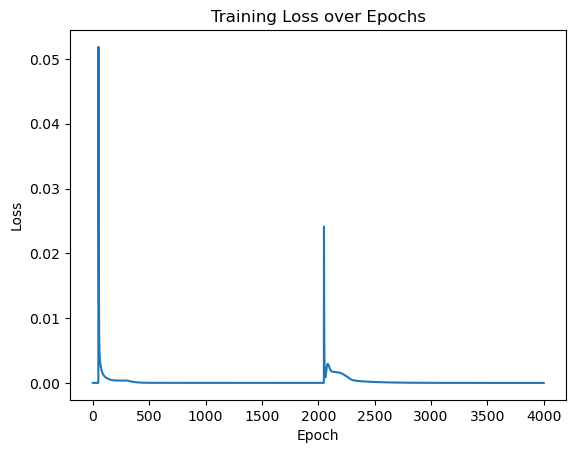

In [191]:
# Plotting the loss
plt.plot(range(simu_epochs), simu_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([0,0.01])
plt.title('Training Loss over Epochs')
# plt.savefig('abb05_loss.png')
plt.show()

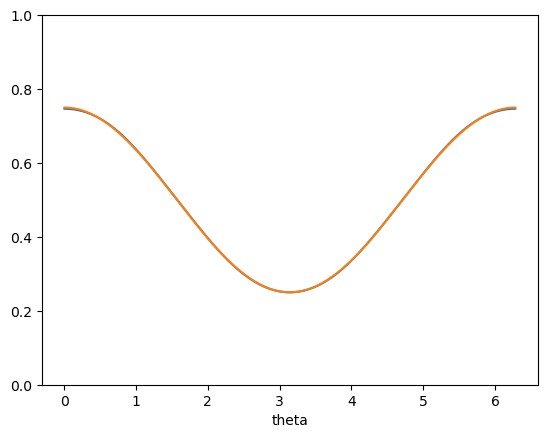

In [192]:
# Plotting the outputs
model.eval()
outputs = []
for x in xs:
    output = model(x)
    outputs.append(output.item())
plt.plot(xs, outputs)
plt.plot(xs, ys, label='target')
plt.ylim([0,1])
plt.xlabel("theta")
# plt.savefig('abb05_outputs.png')
plt.show()

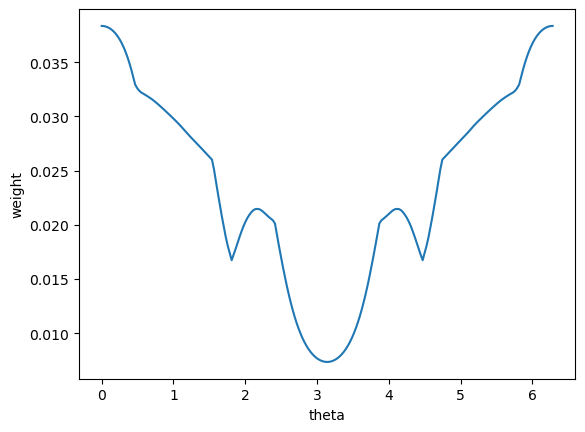

In [193]:
final_weight = model.weights.detach().numpy()
plt.plot(np.linspace(0, 2 * np.pi, model.input_size), final_weight.flatten())
# plt.ylim([0,8])
plt.xlabel("theta")
plt.ylabel("weight")
# plt.savefig('abb05_ws.png')
plt.show()

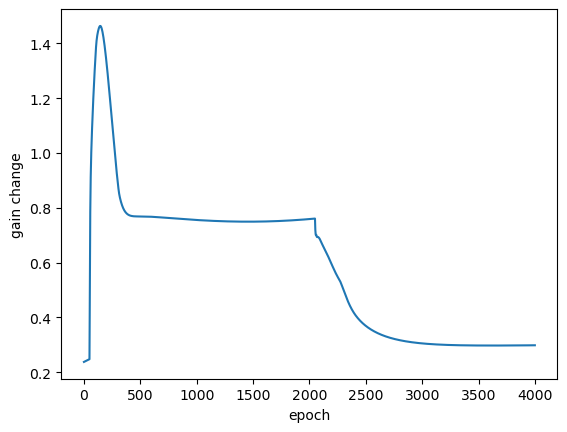

In [194]:
plt.plot(np.arange(simu_epochs), gain_changes)
plt.xlabel("epoch")
plt.ylabel("gain change")
# plt.hlines(y=np.sqrt(460)*0.1, xmin=0, xmax=epochs)
# plt.savefig('abb05_gc.png')
plt.show()

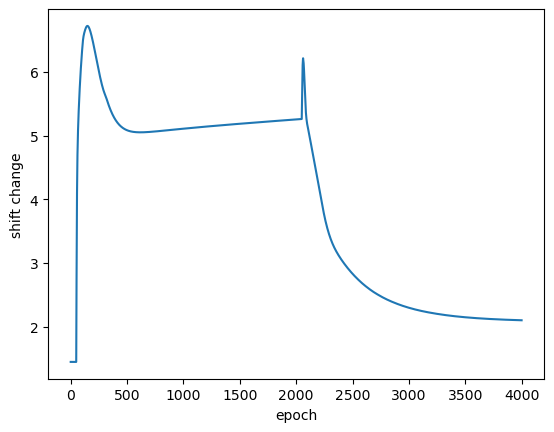

In [195]:
plt.plot(np.arange(simu_epochs), shift_changes)
plt.xlabel("epoch")
plt.ylabel("shift change")
# plt.hlines(y=np.sqrt(460)*0.1, xmin=0, xmax=epochs)
# plt.savefig('abb05_sc.png')
plt.show()

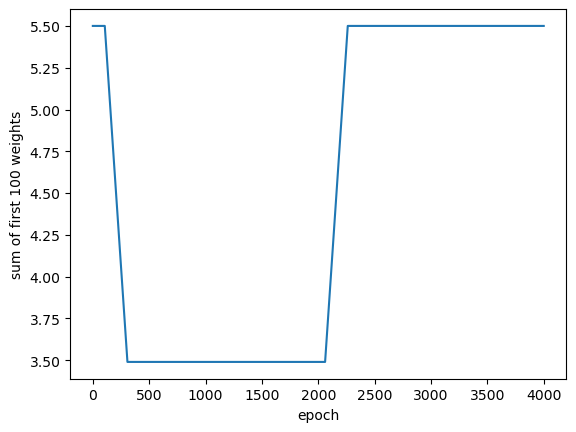

In [196]:
plt.plot(np.arange(simu_epochs), weight_sums)
# plt.ylim([0,8])
plt.xlabel("epoch")
plt.ylabel("sum of first 100 weights")
# plt.savefig('abb05_ws.png')
plt.show()

In [197]:
rates = []
for x in xs:
    input = model.gaussian_rf(x)
    rate = model.activation_func(model.gain * (input - model.shift))
    rates.append(rate)
rates = torch.cat(rates, dim=1)
rates = rates.detach().numpy().round(4)
rates

array([[0.5586, 0.5582, 0.5571, ..., 0.5571, 0.5582, 0.5586],
       [0.5582, 0.5584, 0.558 , ..., 0.5554, 0.5572, 0.5582],
       [0.557 , 0.5579, 0.5581, ..., 0.553 , 0.5554, 0.557 ],
       ...,
       [0.557 , 0.5554, 0.553 , ..., 0.5581, 0.5579, 0.557 ],
       [0.5582, 0.5572, 0.5554, ..., 0.558 , 0.5584, 0.5582],
       [0.5586, 0.5582, 0.5571, ..., 0.5571, 0.5582, 0.5586]],
      dtype=float32)

Text(0, 0.5, 'firing rate')

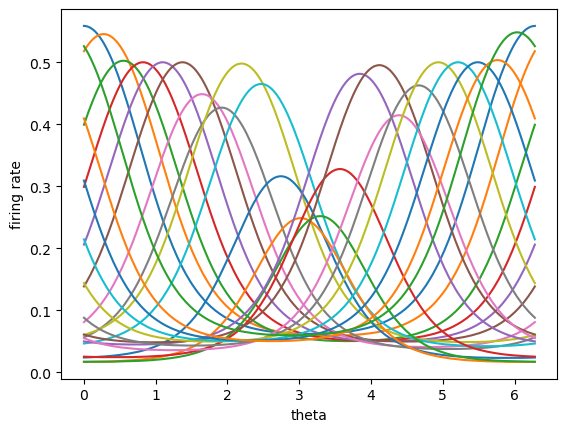

In [198]:
for i in np.arange(0,model.input_size,10):
    thisr = rates[i,:]
    plt.plot(xs, thisr)
plt.xlabel("theta")
plt.ylabel("firing rate")
# plt.savefig('abb05_rf.png')

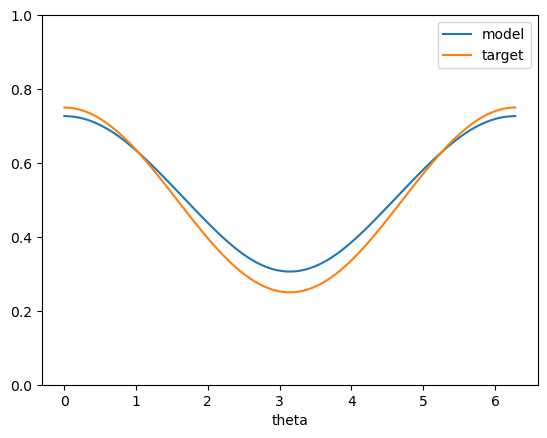

In [199]:
# Plotting the outputs
model.gain = model.init_gain
model.shift = model.init_shift
model.eval()
outputs = []
for x in xs:
    output = model(x)
    outputs.append(output.item())
plt.plot(xs, outputs, label='model')
plt.plot(xs, ys, label='target')
plt.ylim([0,1])
plt.xlabel("theta")
plt.legend()
# plt.savefig('abb05_outputs_nosup.png')

### Compare Different Perturbation Lasts

In [200]:
# manual simulation
perturb_lasts = [500, 1000, 2000]

all_simu_losses = []
all_gain_changes = []
all_shift_changes = []
all_weight_sums = []

for perturb_last in perturb_lasts:

    print(f"perturb_last: {perturb_last}")

    simu_epochs = 4000
    perturb_start = 50
    # perturb_last = 500
    input_size = 230
    theo_gain = 3 * np.ones((input_size, 1))
    theo_shift = 1 * np.ones((input_size, 1))
    init_gain = model_rep.gain.detach().numpy()
    init_shift = model_rep.shift.detach().numpy()
    init_weight = model_rep.weights.detach().numpy()
    hebbian_lr = 0.03
    max_hebbian_lr = 0.001
    hebbian_up_rate = max_hebbian_lr / 200
    hebb_alpha = 5.5
    hebb_alpha_origin = 5.5
    hebb_alpha_perturb = 3.5
    hebb_alpha_up_rate = (hebb_alpha_perturb - hebb_alpha) / 200
    backprop_lr = 0.2
    has_backprop = True
    has_boundary = False
    has_hebbian = True
    has_perturb = False

    # define noise
    np.random.seed(42)
    W = np.eye(input_size) * 0.001
    x_noises = (np.random.multivariate_normal(mean=np.zeros(input_size), cov=W, size=simu_epochs)).T * 0
    x_noises = torch.tensor(x_noises, dtype=torch.float32)
    x_noises[:,perturb_start:perturb_start+perturb_last] += 0.1

    simu_losses = []
    gain_changes = []
    shift_changes = []
    weight_sums = []
    epoch_loss = 0

    for epoch in tqdm(range(simu_epochs), position=0, leave=True):
        if epoch == perturb_start:
            has_perturb = True
            has_hebbian = False
            has_boundary = False
            hebbian_lr = 0
            print("perturbation start!!!")
        if epoch == perturb_start + perturb_last:
            has_perturb = False
            has_hebbian = False
            has_boundary = False
            hebbian_lr = 0
            print("perturbation end!!!")
        
        # shuffle data
        perm_idx = torch.randperm(ndata)
        shuffled_xs = xs[perm_idx]
        shuffled_ys = ys[perm_idx]
        last_epoch_loss = epoch_loss
        epoch_loss = 0
        hebbian_update = torch.zeros_like(torch.tensor(init_weight))

        # establish model
        model = SimpleNeuralNetwork(input_size, init_gain, init_shift, init_weight)

        # start hebbian and shrinkage
        if has_perturb and epoch > perturb_start + 10 and last_epoch_loss < 0.001 and has_hebbian == False:
            has_hebbian = True
            print("perturb learning start!!!")
        if not has_perturb and epoch > perturb_start + perturb_last + 10 and last_epoch_loss < 0.001 and has_hebbian == False:
            has_hebbian = True
            print("origin learning start!!!")
        # if has_perturb and epoch > perturb_start + 10 and last_epoch_loss < 0.001 and has_boundary == False:
        #     gain_ub = np.maximum(init_gain, theo_gain)
        #     gain_lb = np.minimum(init_gain, theo_gain)
        #     shift_ub = np.maximum(init_shift, theo_shift)
        #     shift_lb = np.minimum(init_shift, theo_shift)
        #     has_boundary = True
        #     print("perturb boundary created!!!")
        if not has_perturb and epoch > perturb_start + perturb_last + 10 and last_epoch_loss < 0.001 and has_boundary == False:
            gain_ub = np.maximum(init_gain, theo_gain)
            gain_lb = np.minimum(init_gain, theo_gain)
            shift_ub = np.maximum(init_shift, theo_shift)
            shift_lb = np.minimum(init_shift, theo_shift)
            has_boundary = True
            print("origin boundary created!!!")
     
        # update hebbian learning rate, once per epoch
        if has_hebbian and hebbian_lr < max_hebbian_lr:
            hebbian_lr += hebbian_up_rate
        if has_hebbian and has_perturb and hebb_alpha > hebb_alpha_perturb:
            hebb_alpha += hebb_alpha_up_rate
        if has_hebbian and not has_perturb and hebb_alpha < hebb_alpha_origin:
            hebb_alpha -= hebb_alpha_up_rate
        
        # go through all data
        for x, y in zip(shuffled_xs, shuffled_ys):  
            # forward
            inpu_ipl = model.gaussian_rf(x)
            actv_ipl = model.activation_func(model.gain * (inpu_ipl - model.shift)) + (x_noises[:, epoch]).reshape(-1, 1)
            # actv_ipl = model.activation_func(model.gain * (inpu_ipl - model.shift))
            model.input_activation = actv_ipl.clone()
            inpu_opl = torch.matmul(model.weights, actv_ipl)
            actv_opl = model.activation_func(3 * (inpu_opl - 1))
            model.output_activation = actv_opl.clone()          
            output = actv_opl.squeeze()
            # Calculate loss
            loss_func = nn.MSELoss()
            loss = 0.5 * loss_func(output, y)
            epoch_loss += loss
            # Calculate Hebbian weight updates
            hebbian_update += model.output_activation * (model.input_activation).T

        # backprop for gains and shifts
        if has_backprop:
            optimizer = optim.SGD([model.gain, model.shift], lr=backprop_lr)
            epoch_loss.backward()
            optimizer.step()
        # update init gains and shifts
        init_gain = model.gain.detach().numpy()
        init_shift = model.shift.detach().numpy()
        gain_change = np.linalg.norm(init_gain - theo_gain, 2)
        shift_change = np.linalg.norm(init_shift - theo_shift, 2)

        # hebbian learning for weights
        if has_hebbian:
            # Apply Hebbian updates and normalize
            model.weights = model.weights + hebbian_lr * hebbian_update
            model.weights = model.weights / torch.sum(model.weights) * hebb_alpha
        # update init weights
        init_weight = model.weights.detach().numpy()

        # shrink shift and gain to init value
        if has_boundary:
            # passively narrow the boundaries
            # gain_ub = np.maximum(np.minimum(init_gain, gain_ub), theo_gain)
            # gain_lb = np.minimum(np.maximum(init_gain, gain_lb), theo_gain)
            # shift_ub = np.maximum(np.minimum(init_shift, shift_ub), theo_shift)
            # shift_lb = np.minimum(np.maximum(init_shift, shift_lb), theo_shift)
            # pull gains and shifts back to into boundaries
            init_gain = np.minimum(init_gain, gain_ub)
            init_gain = np.maximum(init_gain, gain_lb)
            init_shift = np.minimum(init_shift, shift_ub)
            init_shift = np.maximum(init_shift, shift_lb)

        # print losses
        epoch_loss /= ndata
        if epoch % 100 == 0:
            print(f"Epoch: {epoch}, Loss: {epoch_loss}")

        # record
        simu_losses.append(epoch_loss.item())
        weight_sums.append(np.sum(init_weight))
        gain_changes.append(gain_change)
        shift_changes.append(shift_change)
    
    # record
    all_simu_losses.append(simu_losses)
    all_gain_changes.append(gain_changes)
    all_shift_changes.append(shift_changes)
    all_weight_sums.append(weight_sums)

perturb_last: 500


  0%|          | 3/4000 [00:00<03:02, 21.91it/s]

Epoch: 0, Loss: 6.917842711118283e-06


  1%|▏         | 55/4000 [00:01<01:28, 44.66it/s]

perturbation start!!!


  3%|▎         | 110/4000 [00:02<01:25, 45.38it/s]

Epoch: 100, Loss: 0.0010998103534802794
perturb learning start!!!


  5%|▌         | 210/4000 [00:04<01:23, 45.22it/s]

Epoch: 200, Loss: 0.0003778740356210619


  8%|▊         | 310/4000 [00:06<01:21, 45.27it/s]

Epoch: 300, Loss: 0.0003687353746499866


 10%|█         | 410/4000 [00:09<01:20, 44.85it/s]

Epoch: 400, Loss: 7.564297993667424e-05


 13%|█▎        | 505/4000 [00:11<01:16, 45.46it/s]

Epoch: 500, Loss: 1.936627086251974e-05


 14%|█▍        | 555/4000 [00:12<01:16, 45.30it/s]

perturbation end!!!


 14%|█▍        | 570/4000 [00:12<01:15, 45.40it/s]

origin learning start!!!
origin boundary created!!!


 15%|█▌        | 610/4000 [00:13<01:14, 45.31it/s]

Epoch: 600, Loss: 0.002998628653585911


 18%|█▊        | 710/4000 [00:15<01:12, 45.51it/s]

Epoch: 700, Loss: 0.0011446040589362383


 20%|██        | 805/4000 [00:17<01:10, 45.63it/s]

Epoch: 800, Loss: 0.00048584170872345567


 23%|██▎       | 905/4000 [00:20<01:09, 44.61it/s]

Epoch: 900, Loss: 0.00023196397523861378


 25%|██▌       | 1010/4000 [00:22<01:05, 45.67it/s]

Epoch: 1000, Loss: 0.00011442089453339577


 28%|██▊       | 1110/4000 [00:24<01:03, 45.36it/s]

Epoch: 1100, Loss: 6.503678014269099e-05


 30%|███       | 1210/4000 [00:26<01:00, 45.83it/s]

Epoch: 1200, Loss: 3.7131623685127124e-05


 33%|███▎      | 1310/4000 [00:29<00:58, 45.83it/s]

Epoch: 1300, Loss: 2.1565698261838406e-05


 35%|███▌      | 1410/4000 [00:31<00:57, 45.44it/s]

Epoch: 1400, Loss: 1.274153601116268e-05


 38%|███▊      | 1510/4000 [00:33<00:54, 45.98it/s]

Epoch: 1500, Loss: 7.833479685359634e-06


 40%|████      | 1610/4000 [00:35<00:52, 45.56it/s]

Epoch: 1600, Loss: 5.02670809510164e-06


 43%|████▎     | 1710/4000 [00:38<00:50, 45.37it/s]

Epoch: 1700, Loss: 3.4157867503381567e-06


 45%|████▌     | 1810/4000 [00:40<00:48, 45.40it/s]

Epoch: 1800, Loss: 2.5204417397617362e-06


 48%|████▊     | 1910/4000 [00:42<00:46, 45.42it/s]

Epoch: 1900, Loss: 2.014842721109744e-06


 50%|█████     | 2010/4000 [00:44<00:43, 45.56it/s]

Epoch: 2000, Loss: 1.7238177179024206e-06


 53%|█████▎    | 2110/4000 [00:46<00:41, 45.73it/s]

Epoch: 2100, Loss: 1.5593940361213754e-06


 55%|█████▌    | 2210/4000 [00:49<00:39, 45.60it/s]

Epoch: 2200, Loss: 1.4702621911055758e-06


 58%|█████▊    | 2310/4000 [00:51<00:37, 45.66it/s]

Epoch: 2300, Loss: 1.4264556966736563e-06


 60%|██████    | 2410/4000 [00:53<00:35, 45.37it/s]

Epoch: 2400, Loss: 1.409973606314452e-06


 63%|██████▎   | 2510/4000 [00:55<00:32, 45.44it/s]

Epoch: 2500, Loss: 1.4104547290116898e-06


 65%|██████▌   | 2610/4000 [00:57<00:30, 45.52it/s]

Epoch: 2600, Loss: 1.4217184798326343e-06


 68%|██████▊   | 2710/4000 [01:00<00:28, 45.58it/s]

Epoch: 2700, Loss: 1.4401067573999171e-06


 70%|███████   | 2810/4000 [01:02<00:26, 45.55it/s]

Epoch: 2800, Loss: 1.4632988722951268e-06


 73%|███████▎  | 2910/4000 [01:04<00:24, 44.78it/s]

Epoch: 2900, Loss: 1.4899470670570736e-06


 75%|███████▌  | 3010/4000 [01:06<00:21, 45.44it/s]

Epoch: 3000, Loss: 1.519019974693947e-06


 78%|███████▊  | 3110/4000 [01:08<00:19, 45.29it/s]

Epoch: 3100, Loss: 1.550005094941298e-06


 80%|████████  | 3210/4000 [01:11<00:17, 45.43it/s]

Epoch: 3200, Loss: 1.5825144146219827e-06


 83%|████████▎ | 3305/4000 [01:13<00:15, 45.68it/s]

Epoch: 3300, Loss: 1.6162422298293677e-06


 85%|████████▌ | 3410/4000 [01:15<00:12, 45.65it/s]

Epoch: 3400, Loss: 1.6511944522790145e-06


 88%|████████▊ | 3510/4000 [01:17<00:10, 45.73it/s]

Epoch: 3500, Loss: 1.6871970274223713e-06


 90%|█████████ | 3610/4000 [01:20<00:08, 45.63it/s]

Epoch: 3600, Loss: 1.7241073919649352e-06


 93%|█████████▎| 3710/4000 [01:22<00:06, 45.62it/s]

Epoch: 3700, Loss: 1.7618184529055725e-06


 95%|█████████▌| 3810/4000 [01:24<00:04, 45.70it/s]

Epoch: 3800, Loss: 1.8006544451054651e-06


 98%|█████████▊| 3910/4000 [01:26<00:01, 45.22it/s]

Epoch: 3900, Loss: 1.8400772887616768e-06


100%|██████████| 4000/4000 [01:28<00:00, 45.12it/s]


perturb_last: 1000


  0%|          | 3/4000 [00:00<02:46, 23.98it/s]

Epoch: 0, Loss: 6.91784134687623e-06


  1%|▏         | 56/4000 [00:01<01:28, 44.76it/s]

perturbation start!!!


  3%|▎         | 106/4000 [00:02<01:25, 45.39it/s]

Epoch: 100, Loss: 0.001099810702726245
perturb learning start!!!


  5%|▌         | 206/4000 [00:04<01:23, 45.43it/s]

Epoch: 200, Loss: 0.00037787400651723146


  8%|▊         | 306/4000 [00:06<01:20, 45.83it/s]

Epoch: 300, Loss: 0.0003687354037538171


 10%|█         | 406/4000 [00:09<01:18, 45.65it/s]

Epoch: 400, Loss: 7.56430090405047e-05


 13%|█▎        | 506/4000 [00:11<01:16, 45.71it/s]

Epoch: 500, Loss: 1.936626540555153e-05


 15%|█▌        | 606/4000 [00:13<01:15, 44.67it/s]

Epoch: 600, Loss: 1.3895520169171505e-05


 18%|█▊        | 706/4000 [00:15<01:12, 45.40it/s]

Epoch: 700, Loss: 1.3456855413096491e-05


 20%|██        | 806/4000 [00:18<01:10, 45.49it/s]

Epoch: 800, Loss: 1.32995774038136e-05


 23%|██▎       | 906/4000 [00:20<01:07, 45.70it/s]

Epoch: 900, Loss: 1.3129008948453702e-05


 25%|██▌       | 1006/4000 [00:22<01:05, 45.61it/s]

Epoch: 1000, Loss: 1.2953974874108098e-05


 26%|██▋       | 1056/4000 [00:23<01:04, 45.58it/s]

perturbation end!!!


 27%|██▋       | 1066/4000 [00:23<01:04, 45.23it/s]

origin learning start!!!
origin boundary created!!!


 28%|██▊       | 1106/4000 [00:24<01:03, 45.38it/s]

Epoch: 1100, Loss: 0.0026092987973243


 30%|███       | 1206/4000 [00:26<01:01, 45.50it/s]

Epoch: 1200, Loss: 0.0012560907052829862


 33%|███▎      | 1306/4000 [00:29<00:59, 45.44it/s]

Epoch: 1300, Loss: 0.0004409959656186402


 35%|███▌      | 1406/4000 [00:31<00:57, 45.07it/s]

Epoch: 1400, Loss: 0.000231676094699651


 38%|███▊      | 1506/4000 [00:33<00:54, 45.45it/s]

Epoch: 1500, Loss: 0.00013212508929427713


 40%|████      | 1606/4000 [00:35<00:52, 45.39it/s]

Epoch: 1600, Loss: 7.74082654970698e-05


 43%|████▎     | 1706/4000 [00:37<00:50, 45.35it/s]

Epoch: 1700, Loss: 4.7031164285726845e-05


 45%|████▌     | 1806/4000 [00:40<00:56, 39.14it/s]

Epoch: 1800, Loss: 2.884442437789403e-05


 48%|████▊     | 1906/4000 [00:42<00:45, 45.88it/s]

Epoch: 1900, Loss: 1.7850074073066935e-05


 50%|█████     | 2006/4000 [00:44<00:43, 45.44it/s]

Epoch: 2000, Loss: 1.1219156476727221e-05


 53%|█████▎    | 2106/4000 [00:46<00:41, 45.65it/s]

Epoch: 2100, Loss: 7.248176643770421e-06


 55%|█████▌    | 2206/4000 [00:49<00:39, 45.70it/s]

Epoch: 2200, Loss: 4.841973805014277e-06


 58%|█████▊    | 2306/4000 [00:51<00:36, 45.87it/s]

Epoch: 2300, Loss: 3.359408765390981e-06


 60%|██████    | 2406/4000 [00:53<00:35, 45.53it/s]

Epoch: 2400, Loss: 2.452032276778482e-06


 63%|██████▎   | 2506/4000 [00:55<00:32, 45.37it/s]

Epoch: 2500, Loss: 1.9131052795273717e-06


 65%|██████▌   | 2606/4000 [00:57<00:30, 45.49it/s]

Epoch: 2600, Loss: 1.5848074781388277e-06


 68%|██████▊   | 2706/4000 [01:00<00:28, 45.76it/s]

Epoch: 2700, Loss: 1.3822360642734566e-06


 70%|███████   | 2806/4000 [01:02<00:26, 45.51it/s]

Epoch: 2800, Loss: 1.2589489415404387e-06


 73%|███████▎  | 2906/4000 [01:04<00:24, 44.86it/s]

Epoch: 2900, Loss: 1.1858859352287254e-06


 75%|███████▌  | 3006/4000 [01:06<00:21, 45.75it/s]

Epoch: 3000, Loss: 1.1449568546595401e-06


 78%|███████▊  | 3106/4000 [01:09<00:19, 45.20it/s]

Epoch: 3100, Loss: 1.1248328064539237e-06


 80%|████████  | 3206/4000 [01:11<00:17, 45.32it/s]

Epoch: 3200, Loss: 1.1184671393493772e-06


 83%|████████▎ | 3306/4000 [01:13<00:15, 45.49it/s]

Epoch: 3300, Loss: 1.1211924402232398e-06


 85%|████████▌ | 3406/4000 [01:15<00:13, 45.29it/s]

Epoch: 3400, Loss: 1.130120381276356e-06


 88%|████████▊ | 3506/4000 [01:17<00:10, 45.38it/s]

Epoch: 3500, Loss: 1.143399344982754e-06


 90%|█████████ | 3606/4000 [01:20<00:08, 45.86it/s]

Epoch: 3600, Loss: 1.1597825277931406e-06


 93%|█████████▎| 3706/4000 [01:22<00:06, 45.46it/s]

Epoch: 3700, Loss: 1.178551997327304e-06


 95%|█████████▌| 3806/4000 [01:24<00:04, 45.31it/s]

Epoch: 3800, Loss: 1.199116013594903e-06


 98%|█████████▊| 3906/4000 [01:26<00:02, 44.89it/s]

Epoch: 3900, Loss: 1.221124080075242e-06


100%|██████████| 4000/4000 [01:28<00:00, 45.04it/s]


perturb_last: 2000


  0%|          | 2/4000 [00:00<03:56, 16.93it/s]

Epoch: 0, Loss: 6.91784134687623e-06


  1%|▏         | 59/4000 [00:01<01:27, 45.16it/s]

perturbation start!!!


  3%|▎         | 109/4000 [00:02<01:25, 45.48it/s]

Epoch: 100, Loss: 0.001099810004234314
perturb learning start!!!


  5%|▌         | 209/4000 [00:04<01:23, 45.52it/s]

Epoch: 200, Loss: 0.0003778747923206538


  8%|▊         | 304/4000 [00:06<01:34, 38.95it/s]

Epoch: 300, Loss: 0.0003687354037538171


 10%|█         | 409/4000 [00:09<01:19, 45.43it/s]

Epoch: 400, Loss: 7.564303814433515e-05


 13%|█▎        | 509/4000 [00:11<01:16, 45.47it/s]

Epoch: 500, Loss: 1.9366276319487952e-05


 15%|█▌        | 609/4000 [00:13<01:14, 45.34it/s]

Epoch: 600, Loss: 1.389552835462382e-05


 18%|█▊        | 709/4000 [00:15<01:12, 45.58it/s]

Epoch: 700, Loss: 1.345687542197993e-05


 20%|██        | 809/4000 [00:18<01:10, 45.57it/s]

Epoch: 800, Loss: 1.3299580132297706e-05


 23%|██▎       | 909/4000 [00:20<01:08, 45.41it/s]

Epoch: 900, Loss: 1.3129062608641107e-05


 25%|██▌       | 1009/4000 [00:22<01:05, 45.48it/s]

Epoch: 1000, Loss: 1.2953949408256449e-05


 28%|██▊       | 1109/4000 [00:24<01:03, 45.53it/s]

Epoch: 1100, Loss: 1.278188301512273e-05


 30%|███       | 1209/4000 [00:26<01:01, 45.28it/s]

Epoch: 1200, Loss: 1.2613399121619295e-05


 33%|███▎      | 1309/4000 [00:29<00:58, 45.65it/s]

Epoch: 1300, Loss: 1.2447266271919943e-05


 35%|███▌      | 1409/4000 [00:31<00:56, 45.64it/s]

Epoch: 1400, Loss: 1.2282007446628995e-05


 38%|███▊      | 1509/4000 [00:33<00:54, 45.33it/s]

Epoch: 1500, Loss: 1.2116491234337445e-05


 40%|████      | 1609/4000 [00:35<00:52, 45.44it/s]

Epoch: 1600, Loss: 1.1949985491810367e-05


 43%|████▎     | 1709/4000 [00:38<00:50, 45.40it/s]

Epoch: 1700, Loss: 1.1782027286244556e-05


 45%|████▌     | 1809/4000 [00:40<00:48, 45.46it/s]

Epoch: 1800, Loss: 1.1612400157900993e-05


 48%|████▊     | 1909/4000 [00:42<00:45, 45.47it/s]

Epoch: 1900, Loss: 1.1441051356086973e-05


 50%|█████     | 2009/4000 [00:44<00:43, 45.47it/s]

Epoch: 2000, Loss: 1.1268133675912395e-05


 51%|█████▏    | 2059/4000 [00:45<00:42, 45.68it/s]

perturbation end!!!


 52%|█████▏    | 2069/4000 [00:45<00:43, 44.90it/s]

origin learning start!!!
origin boundary created!!!


 53%|█████▎    | 2109/4000 [00:46<00:41, 45.46it/s]

Epoch: 2100, Loss: 0.0022981942165642977


 55%|█████▌    | 2209/4000 [00:49<00:39, 45.48it/s]

Epoch: 2200, Loss: 0.0015128537779673934


 58%|█████▊    | 2309/4000 [00:51<00:37, 45.15it/s]

Epoch: 2300, Loss: 0.0004655812808778137


 60%|██████    | 2409/4000 [00:53<00:35, 45.16it/s]

Epoch: 2400, Loss: 0.00023622193839401007


 63%|██████▎   | 2509/4000 [00:55<00:32, 45.56it/s]

Epoch: 2500, Loss: 0.00014310186088550836


 65%|██████▌   | 2609/4000 [00:57<00:30, 45.54it/s]

Epoch: 2600, Loss: 8.75099649420008e-05


 68%|██████▊   | 2709/4000 [01:00<00:28, 45.43it/s]

Epoch: 2700, Loss: 5.33947313670069e-05


 70%|███████   | 2809/4000 [01:02<00:29, 40.39it/s]

Epoch: 2800, Loss: 3.369989644852467e-05


 73%|███████▎  | 2909/4000 [01:04<00:24, 45.28it/s]

Epoch: 2900, Loss: 2.1405259758466855e-05


 75%|███████▌  | 3009/4000 [01:06<00:21, 46.17it/s]

Epoch: 3000, Loss: 1.371569942421047e-05


 78%|███████▊  | 3109/4000 [01:09<00:19, 45.19it/s]

Epoch: 3100, Loss: 8.933538083510939e-06


 80%|████████  | 3209/4000 [01:11<00:17, 45.59it/s]

Epoch: 3200, Loss: 5.882285677216714e-06


 83%|████████▎ | 3309/4000 [01:13<00:15, 45.47it/s]

Epoch: 3300, Loss: 3.95903225580696e-06


 85%|████████▌ | 3409/4000 [01:15<00:12, 45.56it/s]

Epoch: 3400, Loss: 2.7570893053052714e-06


 88%|████████▊ | 3509/4000 [01:17<00:10, 45.64it/s]

Epoch: 3500, Loss: 1.977254214580171e-06


 90%|█████████ | 3609/4000 [01:20<00:08, 45.30it/s]

Epoch: 3600, Loss: 1.4727016832694062e-06


 93%|█████████▎| 3709/4000 [01:22<00:06, 45.67it/s]

Epoch: 3700, Loss: 1.1471332754808827e-06


 95%|█████████▌| 3809/4000 [01:24<00:04, 45.33it/s]

Epoch: 3800, Loss: 9.374782052873343e-07


 98%|█████████▊| 3909/4000 [01:26<00:01, 45.75it/s]

Epoch: 3900, Loss: 8.028494562495325e-07


100%|██████████| 4000/4000 [01:28<00:00, 45.05it/s]


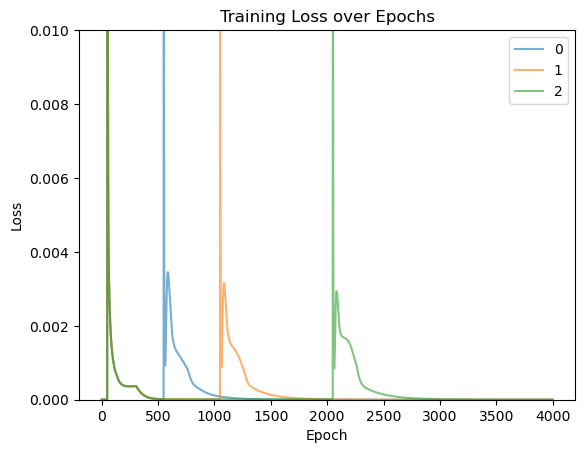

In [201]:
# Plotting the loss
for i, simu_losses in enumerate(all_simu_losses):
    plt.plot(range(simu_epochs), simu_losses, label=i, alpha=0.6)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0,0.01])
plt.title('Training Loss over Epochs')
# plt.savefig('abb05_loss.png')
plt.legend()
plt.show()

In [202]:
for simu_losses in all_simu_losses:
    print(np.max(simu_losses[500::]))

0.024079222232103348
0.02414499595761299
0.024138852953910828


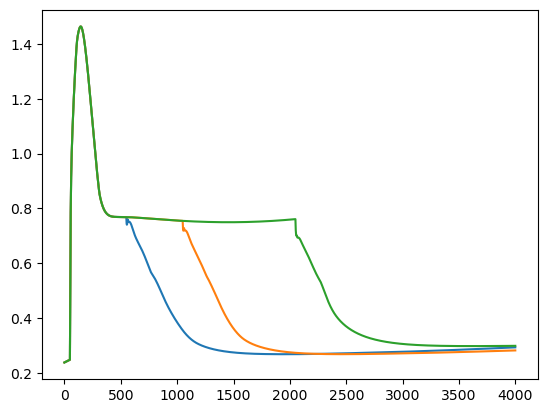

In [203]:
for gain_changes in all_gain_changes:
    plt.plot(np.arange(simu_epochs), gain_changes)

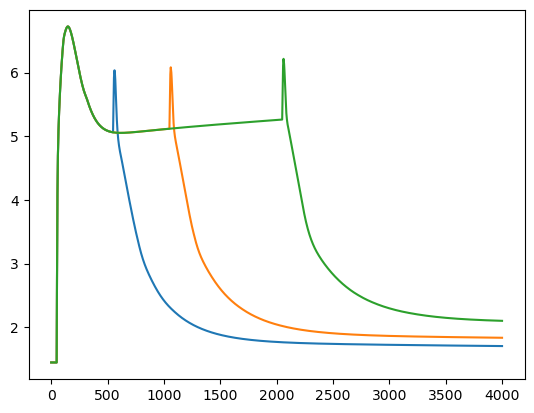

In [204]:
for shift_changes in all_shift_changes:
    plt.plot(np.arange(simu_epochs), shift_changes)